In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from covid_constants_and_util import *
from disease_model import * 
import helper_methods_for_aggregate_data_analysis as helper
from model_experiments import *
from model_results import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as tick
from collections import Counter 
import datetime
from scipy.stats import linregress 
import os
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def make_map_of_disease_spread(
    model,
    data_and_model_kwargs,
    cbg_mapper=None,
    filename=None):

    # Extract mapping data.
    msa_name = data_and_model_kwargs['data_kwargs']['MSA_name']
    if cbg_mapper is None:
        cbg_mapper = helper.CensusBlockGroups(base_directory='/dfs/scratch1/safegraph_homes/external_datasets_for_aggregate_analysis/census_block_group_shapefiles_by_state/',
                                             gdb_files=MSAS_TO_STATE_CBG_FILES[msa_name])
    msa_shapefile = gpd.read_file('/dfs/scratch1/safegraph_homes/external_datasets_for_aggregate_analysis/msa_shapefiles/tl_2017_us_cbsa/').to_crs(WGS_84_CRS)
    msa_shapefile['name_without_spaces'] = msa_shapefile['NAME'].map(
            lambda x:re.sub('[^0-9a-zA-Z]+', '_', x))
    msa_boundary = msa_shapefile.loc[msa_shapefile['name_without_spaces'] == msa_name]
    assert len(msa_boundary) == 1

    # Extract final fraction in LIR by CBG.
    lir_df = pd.DataFrame({'cbg':model.ALL_UNIQUE_CBGS,
                           'total_population':model.CBG_SIZES})

    # Extract where people are going out.
    ipf_output = pickle.load(open(get_ipf_filename(msa_name,
        data_and_model_kwargs['model_kwargs']['min_datetime'],
        data_and_model_kwargs['model_kwargs']['max_datetime'],
        clip_visits=data_and_model_kwargs['model_kwargs']['poi_attributes_to_clip']['clip_visits']), 'rb'))
    timesteps_before_end = range(-168, 0)
    total_n_out_over_week = 0
    for t in timesteps_before_end:
        if t % 24 == 0:
            print("Processing IPF output timestep %i" % t)
        poi_cbg_array = ipf_output[t].toarray()
        assert poi_cbg_array.shape[1] == len(model.CBG_SIZES)
        n_out = poi_cbg_array.sum(axis=0)
        total_n_out_over_week = total_n_out_over_week + n_out
    total_n_out_over_week_per_capita = total_n_out_over_week/model.CBG_SIZES
    lir_df['total_n_out_over_week_per_capita'] = total_n_out_over_week_per_capita

    # Extract true social distancing numbers.
    sdm = helper.load_social_distancing_metrics(
    helper.list_datetimes_in_range(
        data_and_model_kwargs['model_kwargs']['max_datetime'] - datetime.timedelta(days=6),
        data_and_model_kwargs['model_kwargs']['max_datetime']))
    cbg_day_prop_out = helper.compute_cbg_day_prop_out(sdm)
    cols_to_average = [a for a in cbg_day_prop_out.columns if a != 'census_block_group']
    cbg_day_prop_out['mean_frac_out_from_sdm'] = cbg_day_prop_out[cols_to_average].values.mean(axis=1)

    lir_df = pd.merge(lir_df, cbg_day_prop_out[['mean_frac_out_from_sdm', 'census_block_group']],
        how='inner', left_on='cbg', right_on='census_block_group', validate='one_to_one')

    # match to geometry D.
    geometry_d = cbg_mapper.geometry_d.copy()
    geometry_d['cbg'] = geometry_d['GEOID_Data'].map(lambda x:x.split("US")[1]).astype(int)
    geometry_d = pd.merge(geometry_d,
                          lir_df,
                          on='cbg',
                          how='inner',
                          validate='one_to_one')


    acs_d = helper.load_and_reconcile_multiple_acs_data()[['p_black_2017_5YR',  'p_white_2017_5YR',
    'median_household_income_2017_5YR', 'census_block_group', 'people_per_mile_hybrid']]
    geometry_d = pd.merge(geometry_d,
        acs_d,
        left_on='cbg',
        right_on='census_block_group',
        how='inner',
        validate='one_to_one')
    print("Matched %i CBGs out of %i in SafeGraph data" % (len(geometry_d), len(lir_df)))

    all_cols_to_plot = ['people_per_mile_hybrid', 'total_n_out_over_week_per_capita', 'median_household_income_2017_5YR', 'p_black_2017_5YR', 'mean_frac_out_from_sdm']
    geometry_d = geometry_d.dropna(subset=all_cols_to_plot)
    print("After dropping NAs, %i rows" % len(geometry_d))

    # Filter for CBGs in MSA (just for plotting).
    nyt_outcomes, nyt_counties, nyt_cbgs, msa_counties, msa_cbgs = get_variables_for_evaluating_msa_model(msa_name)
    msa_cbgs = set(msa_cbgs)
    geometry_d = geometry_d.loc[geometry_d['cbg'].map(lambda x:x in msa_cbgs)]
    print("After filtering for CBGs in MSA, %i CBGs" % (len(geometry_d)))

    msa_boundary = msa_shapefile.loc[msa_shapefile['name_without_spaces'] == msa_name]
        
    return cbg_mapper, geometry_d, msa_boundary


In [5]:
# Load models after grid search
min_timestring = '2020_07_16_10_4'
max_timestring = '2020_07_18'
df = evaluate_all_fitted_models_for_experiment('normal_grid_search', 
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring)
df['MSA_name'] = df['data_kwargs'].map(lambda x:x['MSA_name'])
ablation_df = df.loc[df['poi_psi'] == 0].copy()
non_ablation_df = df.loc[df['poi_psi'] > 0].copy()
df = None

Loading models with timestrings between 2020_07_16_10_4 and 2020_07_18
82265 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 17000 fitted models for normal_grid_search
Loaded 1 models so far: 0.082s -> 0.082s per model
Loaded 1001 models so far: 19.026s -> 0.019s per model
Loaded 2001 models so far: 39.396s -> 0.020s per model
Loaded 3001 models so far: 60.873s -> 0.020s per model
Loaded 4001 models so far: 80.528s -> 0.020s per model
Loaded 5001 models so far: 99.686s -> 0.020s per model
Loaded 6001 models so far: 119.565s -> 0.020s per model
Loaded 7001 models so far: 137.173s -> 0.020s per model
Loaded 8001 models so far: 158.781s -> 0.020s per model
Loaded 9001 models so far: 180.131s -> 0.020s per model
Loaded 10001 models so far: 202.055s -> 0.020s per model
Loaded 11001 models so far: 221.717s -> 0.020s per model
Loaded 12001 models so far: 244.021s -> 0.020s per model
Loaded 13001 models so far: 265.124s -> 0.020s per model
Loaded 

In [6]:
msa = 'Chicago_Naperville_Elgin_IL_IN_WI'

In [7]:
# for msa in msas:
msa_results = non_ablation_df.loc[non_ablation_df['MSA_name'] == msa]
msa_results = msa_results.sort_values(by='loss_dict_daily_cases_RMSE')
model, data_and_model_kwargs, d, model_results, fast_to_load_results = load_model_and_data_from_timestring(
        msa_results.iloc[0]['timestring'], 
        load_fast_results_only=False,
        load_full_model=True)
model_kwargs = data_and_model_kwargs['model_kwargs']
data_kwargs = data_and_model_kwargs['data_kwargs']
model_kwargs['return_model_and_data_without_fitting'] = True
fitted_model = fit_and_save_one_model(None,
                       model_kwargs,
                       data_kwargs,
                       d=None,
                       experiment_to_run=None,
                       train_test_partition=None)

Fitting single model. Timestring is none so not saving model and just returning fitted model.
Loaded 108556 rows for Chicago_Naperville_Elgin_IL_IN_WI in 114.535 seconds
Reloading POI visits from /dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
1. Processing SafeGraph data...
Found 1512 hours in all (2020.3.1.0 to 2020.5.2.23) -> 26022321 hourly visits
Aggregating median_dwell from 2020-03-01.median_dwell to 2020-04-26.median_dwell
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be clipping hourly visits in dataframe
Clipping areas: True (below=5, above=95), clipping dwell times: True (above=90), clipping visits: False (above=95)


/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Found 105 sub-categories with >= 100 POIs and 48 top categories with >= 50 POIs -> covers 107393 POIs
Could not cover 1163/108556 POIs (1.1% POIs, 0.8% hourly visits) -> dropping these POIs
Activities Related to Credit Intermediation -> has 71 POIs, processed 71 POIs
Amusement Parks and Arcades -> has 120 POIs, processed 11 POIs
Automotive Parts, Accessories, and Tire Stores -> has 1666 POIs, processed 36 POIs
Automotive Repair and Maintenance -> has 4055 POIs, processed 210 POIs
Beverage Manufacturing -> has 256 POIs, processed 51 POIs
Building Equipment Contractors -> has 133 POIs, processed 2 POIs
Building Material and Supplies Dealers -> has 2089 POIs, processed 33 POIs
Clothing Stores -> has 2170 POIs, processed 172 POIs
Commercial and Industrial Machinery and Equipment Rental and Leasing -> has 64 POIs, processed 64 POIs
Consumer Goods Rental -> has 129 POIs, processed 21 POIs
Death Care Services -> has 74 POIs, processed 74 POIs
Depository Credit Intermediation -> has 2205 POIs,

After clipping, 107393 POIs
After dropping for missing hourly visits, 73875 POIs
After dropping for missing CBG home data, 62468 POIs
After dropping for missing avg_median_dwell, 62468 POIs
After dropping CBGs that appear in < 10 POIs, 6812 CBGs (62.9%)
Dropped 48 POIs whose visitors all come from dropped CBGs
FINAL: number of CBGs (N) = 6812, number of POIs (M) = 62420
Num connected POI-CBG pairs (E) = 896138, network density (E/N) = 131.553
6590 CBGs in nyt -> matched 6535 (0.992)
Dwell time correction factors: mean = 0.15, min = 0.01, max = 0.84
Precomputed POI-CBG networks (IPF output) were passed in; will NOT be applying correction to hourly visits in dataframe
2. Processing ACS data...
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
CBGs: median population size = 1295, sum of population sizes = 10169539
Removing 0.617% of people from SafeGraph count who are not in 50 states or DC
Total US population from ACS: 322903030; total safegraph visitor co

NameError: name 'make_map_of_disease_spread' is not defined

In [16]:
cbg_mapper, geometry_d, msa_boundary = make_map_of_disease_spread(model, 
        data_and_model_kwargs=data_and_model_kwargs,
        filename='%s_map.png' % msa)
plt.show()

ACS_2017_5YR_BG_17_ILLINOIS.gdb
['X00_COUNTS', 'X01_AGE_AND_SEX', 'X02_RACE', 'X03_HISPANIC_OR_LATINO_ORIGIN', 'X07_MIGRATION', 'X08_COMMUTING', 'X09_CHILDREN_HOUSEHOLD_RELATIONSHIP', 'X11_HOUSEHOLD_FAMILY_SUBFAMILIES', 'X12_MARITAL_STATUS_AND_HISTORY', 'X14_SCHOOL_ENROLLMENT', 'X15_EDUCATIONAL_ATTAINMENT', 'X16_LANGUAGE_SPOKEN_AT_HOME', 'X17_POVERTY', 'X19_INCOME', 'X20_EARNINGS', 'X21_VETERAN_STATUS', 'X22_FOOD_STAMPS', 'X23_EMPLOYMENT_STATUS', 'X24_INDUSTRY_OCCUPATION', 'X25_HOUSING_CHARACTERISTICS', 'X27_HEALTH_INSURANCE', 'X99_IMPUTATION', 'BG_METADATA_2017', 'ACS_2017_5YR_BG_17_ILLINOIS']
Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'Shape_Length', 'Shape_Area', 'GEOID_Data', 'geometry'],
      dtype='object')
Length of demographic data: 9691; geographic data 9691; 9691 GEOIDs in both
ACS_2017_5YR_BG_18_INDIANA.gdb
['X00_COUNTS', 'X01_AGE_AND_SEX', 'X02_RACE', 'X03_HISPANIC_

/dfs/scratch1/safegraph_homes/safegraph_env_v3/safegraph_env_v3/lib/python3.7/site-packages/ipykernel_launcher.py:26: ResourceWarning: unclosed file <_io.BufferedReader name='/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl'>


Processing IPF output timestep -168
Processing IPF output timestep -144
Processing IPF output timestep -120
Processing IPF output timestep -96
Processing IPF output timestep -72
Processing IPF output timestep -48
Processing IPF output timestep -24
Loading social distancing metrics for 7 datetimes; using version v2
Total time to load social distancing metrics: 35.925 seconds; total rows 219651
Kept 218694 / 219651 CBGs with non-NaN SDM for days of interest
Found SDM data for 218694 / 218694 CBGs of interest
220333 rows of 2018 1-year ACS data read
217739 rows of 2017 5-year ACS data read
Matched 6783 CBGs out of 6805 in SafeGraph data
After dropping NAs, 6604 rows
After filtering for CBGs in MSA, 6354 CBGs


In [19]:
msas = [msa]
import shapely
from shapely.geometry import mapping
from mpl_toolkits.mplot3d import Axes3D

## Set plotting aesthetics
boundary_linewidth = 0.5
# poi_color = 'tab:blue'
# cbg_color = 'tab:orange'
# edge_color = 'tab:gray'
# poi_color = 'royalblue'
# cbg_color = 'sandybrown'
# edge_color = 'slategrey'
poi_color = 'mediumpurple'
cbg_color = 'forestgreen'
edge_color = 'dimgray'

scale_z = 0.3
visit_threshold = 5

# CBG is z-axis = 0, POI is z-axis 1
cbg_z = 0
poi_z = 1

plt.style.use('seaborn-paper')


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f506e8d2d90> (for post_execute):


AttributeError: 'Axes3DSubplot' object has no attribute 'vvec'

AttributeError: 'Axes3DSubplot' object has no attribute 'vvec'

<Figure size 864x864 with 1 Axes>

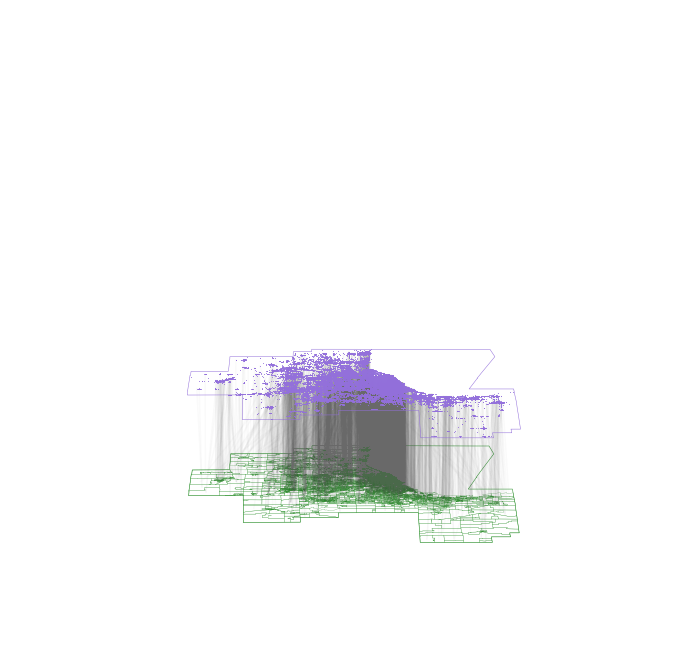

In [23]:
target_time = 12 # 1pm
target_dates = [
    datetime.datetime(2020, 3, 2, 0, 0), # March 2, 2020, Monday
    datetime.datetime(2020, 4, 6, 0, 0) # April 6, 2020, Monday
]
t_idxs = [
    (target_time + (target_date - model_kwargs['min_datetime']).days * 24)
    for target_date in target_dates]

## Get CBG coords
n_cbgs = len(geometry_d)
cbg_coords = np.zeros((n_cbgs, 2))
for idx in range(n_cbgs):
    centroid = geometry_d['geometry'].iloc[idx].centroid
    cbg_coords[idx, 0] = centroid.x
    cbg_coords[idx, 1] = centroid.y

## Get POI coords
poi_d = fitted_model.d
n_pois = len(poi_d)
poi_coords = np.zeros((n_pois, 2))
for idx in range(n_pois):
    centroid = shapely.wkt.loads(poi_d['polygon_wkt'].iloc[idx]).centroid
    poi_coords[idx, 0] = centroid.x
    poi_coords[idx, 1] = centroid.y

## Get MSA boundaries
msa_boundary_coords = np.array(mapping(msa_boundary.boundary)['features'][0]['geometry']['coordinates'])
if len(msa_boundary_coords.shape) == 1: # Just take first MSA boundary
    msa_boundary_coords = np.array(mapping(msa_boundary.boundary)['features'][0]['geometry']['coordinates'][0])


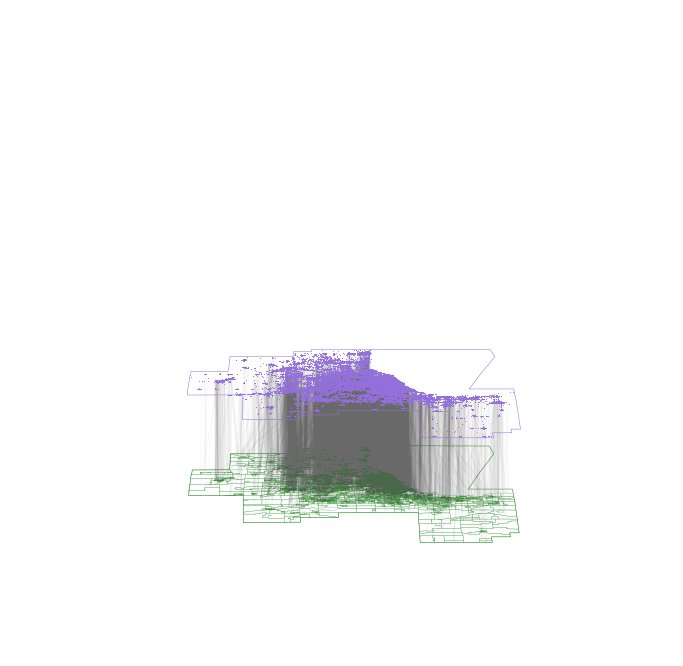

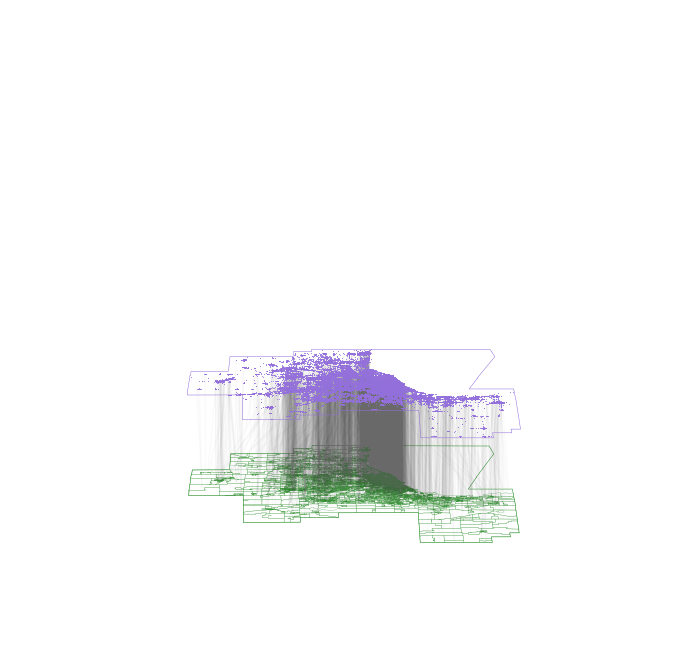

In [43]:
## Make one plot for each hour we're interested in
visit_threshold = 6

for t_idx in t_idxs:

    # Find the indices of the CBGs that we actually plot
    cbg_idx = [np.argwhere(geometry_d['cbg'].iloc[i] == fitted_model.ALL_UNIQUE_CBGS)[0][0] for i in range(n_cbgs)] 

    # Make sure we matched all CBGs
    assert len(cbg_idx) == n_cbgs 
    visit_mat = fitted_model.POI_CBG_VISITS_LIST[t_idx][:, cbg_idx]
    visit_threshold_mask = visit_mat > visit_threshold

    # Make sure that POIs match up too
    assert len(poi_d) == visit_mat.shape[0]    

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.get_proj = lambda: np.dot(
        Axes3D.get_proj(ax), 
        np.diag([1, 1, scale_z, 1]))

    # Plot CBG boundaries 
    for cbg in range(n_cbgs):
        for geom in geometry_d['geometry'].iloc[cbg].geoms:
            coords = np.array(geom.exterior.coords)
            ax.plot(
                coords[:, 0],
                coords[:, 1],
                zs=cbg_z,
                c=cbg_color,
                linewidth=0.2
            )
    ax.plot(
        msa_boundary_coords[:, 0], 
        msa_boundary_coords[:, 1], 
        zs=cbg_z, 
        linewidth=boundary_linewidth,
        c=cbg_color)

    ## Plot visits above the threshold
    pois_above_threshold, cbgs_above_threshold = visit_threshold_mask.nonzero()
    for (poi, cbg) in zip(pois_above_threshold, cbgs_above_threshold):
        ax.plot(
            (cbg_coords[cbg, 0], poi_coords[poi, 0]),
            (cbg_coords[cbg, 1], poi_coords[poi, 1]),
            zs = (cbg_z, poi_z),
            alpha=0.03,
    #         alpha = 0.03 + (visit_mat[poi, cbg] / 120) * 0.07,
            c=edge_color)

    ## Plot POIs
    ax.plot(
        poi_coords[:, 0], 
        poi_coords[:, 1], 
        '.',
        zs=poi_z,
        markersize=2,
        c=poi_color,
    )
    ax.plot(
        msa_boundary_coords[:, 0], 
        msa_boundary_coords[:, 1], 
        zs=poi_z, 
        linewidth=boundary_linewidth,
        c=poi_color)

    ax.view_init(15, 270)
    plt.axis('off')

    plt.savefig(f'covid_figures_for_paper/network_maps/{msa}_t-{t_idx}_thres-{visit_threshold}_network_map.pdf', bbox_inches='tight', dpi=600)
    plt.savefig(f'covid_figures_for_paper/network_maps/{msa}_t-{t_idx}_thres-{visit_threshold}_network_map.svg', bbox_inches='tight', dpi=600)

(-89.04293895000295, -86.82870604993798, 40.639840199825436, 42.76657580007319)

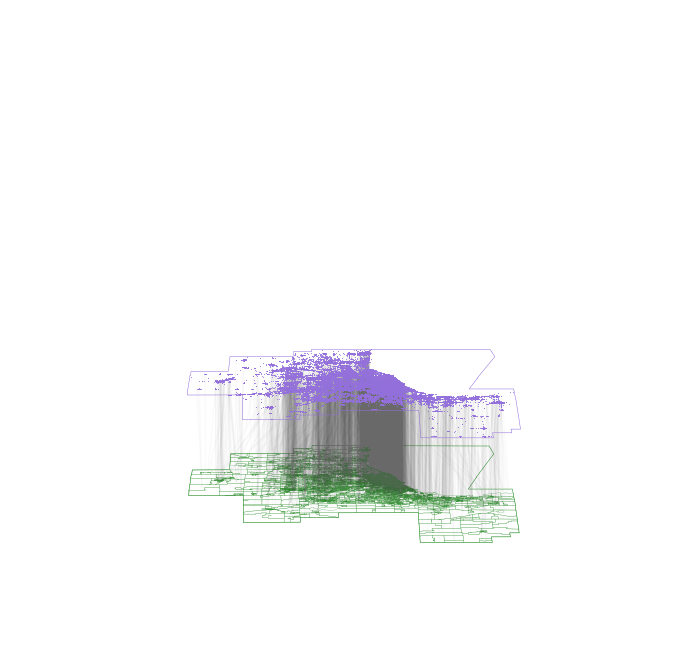

In [41]:
t_idx = t_idxs[1]
visit_threshold = 7

# Find the indices of the CBGs that we actually plot
cbg_idx = [np.argwhere(geometry_d['cbg'].iloc[i] == fitted_model.ALL_UNIQUE_CBGS)[0][0] for i in range(n_cbgs)] 

# Make sure we matched all CBGs
assert len(cbg_idx) == n_cbgs 
visit_mat = fitted_model.POI_CBG_VISITS_LIST[t_idx][:, cbg_idx]
visit_threshold_mask = visit_mat > visit_threshold

# Make sure that POIs match up too
assert len(poi_d) == visit_mat.shape[0]    

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

ax.get_proj = lambda: np.dot(
    Axes3D.get_proj(ax), 
    np.diag([1, 1, scale_z, 1]))

# Plot CBG boundaries 
for cbg in range(n_cbgs):
    for geom in geometry_d['geometry'].iloc[cbg].geoms:
        coords = np.array(geom.exterior.coords)
        ax.plot(
            coords[:, 0],
            coords[:, 1],
            zs=cbg_z,
            c=cbg_color,
            linewidth=0.2
        )
ax.plot(
    msa_boundary_coords[:, 0], 
    msa_boundary_coords[:, 1], 
    zs=cbg_z, 
    linewidth=boundary_linewidth,
    c=cbg_color)

## Plot visits above the threshold
pois_above_threshold, cbgs_above_threshold = visit_threshold_mask.nonzero()
for (poi, cbg) in zip(pois_above_threshold, cbgs_above_threshold):
    ax.plot(
        (cbg_coords[cbg, 0], poi_coords[poi, 0]),
        (cbg_coords[cbg, 1], poi_coords[poi, 1]),
        zs = (cbg_z, poi_z),
        alpha=0.03,
#         alpha = 0.03 + (visit_mat[poi, cbg] / 120) * 0.07,
        c=edge_color)

## Plot POIs
ax.plot(
    poi_coords[:, 0], 
    poi_coords[:, 1], 
    '.',
    zs=poi_z,
    markersize=2,
    c=poi_color,
)
ax.plot(
    msa_boundary_coords[:, 0], 
    msa_boundary_coords[:, 1], 
    zs=poi_z, 
    linewidth=boundary_linewidth,
    c=poi_color)

ax.view_init(15, 270)
plt.axis('off')


In [29]:
target_time = 12 # 1pm
target_dates = [
    datetime.datetime(2020, 3, 2, 0, 0), # March 2, 2020, Monday
    datetime.datetime(2020, 4, 6, 0, 0) # April 6, 2020, Monday
]
t_idxs = [
    (target_time + (target_date - model_kwargs['min_datetime']).days * 24)
    for target_date in target_dates]

for msa in msas:
    msa_results = non_ablation_df.loc[non_ablation_df['MSA_name'] == msa]
    msa_results = msa_results.sort_values(by='loss_dict_daily_cases_RMSE')
    model, data_and_model_kwargs, d, model_results, fast_to_load_results = load_model_and_data_from_timestring(
            msa_results.iloc[0]['timestring'], 
            load_fast_results_only=False,
            load_full_model=True)
    model_kwargs = data_and_model_kwargs['model_kwargs']
    data_kwargs = data_and_model_kwargs['data_kwargs']
    model_kwargs['return_model_and_data_without_fitting'] = True
    fitted_model = fit_and_save_one_model(None,
                           model_kwargs,
                           data_kwargs,
                           d=None,
                           experiment_to_run=None,
                           train_test_partition=None)
    cbg_mapper, geometry_d, msa_boundary = make_map_of_disease_spread(model, 
            data_and_model_kwargs=data_and_model_kwargs,
            filename='%s_map.png' % msa)
    plt.show() 

    ## Get CBG coords
    n_cbgs = len(geometry_d)
    cbg_coords = np.zeros((n_cbgs, 2))
    for idx in range(n_cbgs):
        centroid = geometry_d['geometry'].iloc[idx].centroid
        cbg_coords[idx, 0] = centroid.x
        cbg_coords[idx, 1] = centroid.y

    ## Get POI coords
    poi_d = fitted_model.d
    n_pois = len(poi_d)
    poi_coords = np.zeros((n_pois, 2))
    for idx in range(n_pois):
        centroid = shapely.wkt.loads(poi_d['polygon_wkt'].iloc[idx]).centroid
        poi_coords[idx, 0] = centroid.x
        poi_coords[idx, 1] = centroid.y

    ## Get MSA boundaries
    msa_boundary_coords = np.array(mapping(msa_boundary.boundary)['features'][0]['geometry']['coordinates'])
    if len(msa_boundary_coords.shape) == 1: # Just take first MSA boundary
        msa_boundary_coords = np.array(mapping(msa_boundary.boundary)['features'][0]['geometry']['coordinates'][0])

    ## Make one plot for each hour we're interested in
    for t_idx in t_idxs:

        # Find the indices of the CBGs that we actually plot
        cbg_idx = [np.argwhere(geometry_d['cbg'].iloc[i] == fitted_model.ALL_UNIQUE_CBGS)[0][0] for i in range(n_cbgs)] 

        # Make sure we matched all CBGs
        assert len(cbg_idx) == n_cbgs 
        visit_mat = fitted_model.POI_CBG_VISITS_LIST[t_idx][:, cbg_idx]
        visit_threshold_mask = visit_mat > visit_threshold

        # Make sure that POIs match up too
        assert len(poi_d) == visit_mat.shape[0]    

        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111, projection='3d')

        ax.get_proj = lambda: np.dot(
            Axes3D.get_proj(ax), 
            np.diag([1, 1, scale_z, 1]))

        # Plot CBG boundaries 
        for cbg in range(n_cbgs):
            for geom in geometry_d['geometry'].iloc[cbg].geoms:
                coords = np.array(geom.exterior.coords)
                ax.plot(
                    coords[:, 0],
                    coords[:, 1],
                    zs=cbg_z,
                    c=cbg_color,
                    linewidth=0.2
                )
        ax.plot(
            msa_boundary_coords[:, 0], 
            msa_boundary_coords[:, 1], 
            zs=cbg_z, 
            linewidth=boundary_linewidth,
            c=cbg_color)

        ## Plot visits above the threshold
        pois_above_threshold, cbgs_above_threshold = visit_threshold_mask.nonzero()
        for (poi, cbg) in zip(pois_above_threshold, cbgs_above_threshold):
            ax.plot(
                (cbg_coords[cbg, 0], poi_coords[poi, 0]),
                (cbg_coords[cbg, 1], poi_coords[poi, 1]),
                zs = (cbg_z, poi_z),
                alpha=0.03,
        #         alpha = 0.03 + (visit_mat[poi, cbg] / 120) * 0.07,
                c=edge_color)

        ## Plot POIs
        ax.plot(
            poi_coords[:, 0], 
            poi_coords[:, 1], 
            '.',
            zs=poi_z,
            markersize=2,
            c=poi_color,
        )
        ax.plot(
            msa_boundary_coords[:, 0], 
            msa_boundary_coords[:, 1], 
            zs=poi_z, 
            linewidth=boundary_linewidth,
            c=poi_color)

        ax.view_init(15, 270)
        plt.axis('off')

        plt.savefig(f'covid_figures_for_paper/network_maps/{msa}_t-{t_idx}_network_map.pdf', bbox_inches='tight', dpi=600)
        plt.savefig(f'covid_figures_for_paper/network_maps/{msa}_t-{t_idx}_network_map.svg', bbox_inches='tight', dpi=600)

Fitting single model. Timestring is none so not saving model and just returning fitted model.


KeyboardInterrupt: 

In [63]:
model.groups_to_track_num_cases_per_poi

['all',
 'median_household_income_bottom_decile',
 'median_household_income_top_decile']

In [69]:
mean_cases_per_poi = np.mean(model.history['all']['num_cases_per_poi'], axis=0)

In [145]:
msa = 'Chicago_Naperville_Elgin_IL_IN_WI'
for category_name in [
    'Full-Service Restaurants',
    'Child Day Care Services',
    'Elementary and Secondary Schools',
    'Drinking Places (Alcoholic Beverages)']:
    category_mask = poi_and_cbg_characteristics[msa]['poi_categories'] == category_name
    print(category_name)
    print(f"  avg area: {np.mean(poi_and_cbg_characteristics[msa]['poi_areas'][category_mask])}")
    print(f"  avg dwell time: {np.mean(poi_and_cbg_characteristics[msa]['poi_dwell_times'][category_mask])}")

Full-Service Restaurants
  avg area: 6145.476877815574
  avg dwell time: 35.11551898501425
Child Day Care Services
  avg area: 16460.621104387286
  avg dwell time: 63.74950832072618
Elementary and Secondary Schools
  avg area: 82770.55319926873
  avg dwell time: 56.045155393053015
Drinking Places (Alcoholic Beverages)
  avg area: 7718.289267015705
  avg dwell time: 48.83756544502617


In [144]:
poi_and_cbg_characteristics[msa].keys()

dict_keys(['poi_categories', 'poi_areas', 'poi_dwell_times', 'poi_dwell_time_correction_factors', 'cbg_idx_groups_to_track', 'cbg_sizes'])

In [143]:
np.mean(poi_and_cbg_characteristics[msa]['poi_areas'])

62106.56041493112

In [91]:
category_name = 'Elementary and Secondary Schools'
category_mask = poi_and_cbg_characteristics['Chicago_Naperville_Elgin_IL_IN_WI']['poi_categories'] == category_name
print(f'Number of cases due to {category_name}: {np.sum(mean_cases_per_poi[category_mask])}')
print(f'Total number of cases: {np.sum(mean_cases_per_poi)}')

Number of cases due to Elementary and Secondary Schools: 4858.861435574077
Total number of cases: 492968.79751526355


In [94]:
category_name = 'Full-Service Restaurants'
category_mask = poi_and_cbg_characteristics['Chicago_Naperville_Elgin_IL_IN_WI']['poi_categories'] == category_name
print(f'Number of cases due to {category_name}: {np.sum(mean_cases_per_poi[category_mask])}')
print(f'Total number of cases: {np.sum(mean_cases_per_poi)}')

Number of cases due to Full-Service Restaurants: 109908.97187006597
Total number of cases: 492968.79751526355


In [148]:
for category_name in [
    'Other Gasoline Stations',
    'Other Gas Stations',
    'Gasoline Stations with Convenience Stores',
    'Gas Stations',
    'Full-Service Restaurants',
    'Child Day Care Services',
    'Elementary and Secondary Schools',
    'Drinking Places (Alcoholic Beverages)']:

    frac_dict = {}
    for idx in superspreader_df_cases.index:
        ts = superspreader_df_cases.loc[idx, 'timestring']
        msa = superspreader_df_cases.loc[idx, 'MSA_name']

        model, kwargs, _, model_results, fast_to_load_results = load_model_and_data_from_timestring(
             ts,
             verbose=False,
             load_fast_results_only=False,
             load_full_model=True,
             old_directory=False)
        mean_cases_per_poi = np.mean(model.history['all']['num_cases_per_poi'], axis=0)

        category_mask = poi_and_cbg_characteristics[msa]['poi_categories'] == category_name
        frac_cases_in_category = np.sum(mean_cases_per_poi[category_mask]) / np.sum(mean_cases_per_poi)
#         print(f'Fraction of cases due to {category_name}: {frac_cases_in_category}')

        if msa not in frac_dict:
            frac_dict[msa] = []

        frac_dict[msa].append(frac_cases_in_category)
    
    print(category_name)
    msa_fracs = []
    for msa in frac_dict:
        msa_fracs.append(np.mean(frac_dict[msa]))
        print(msa, np.mean(frac_dict[msa]))
    print(f'Median %: {np.median(np.array(msa_fracs)) * 100}\n')

Other Gasoline Stations
Washington_Arlington_Alexandria_DC_VA_MD_WV 0.0
Los_Angeles_Long_Beach_Anaheim_CA 8.714638533228407e-05
Dallas_Fort_Worth_Arlington_TX 0.00024722615428419395
Houston_The_Woodlands_Sugar_Land_TX 0.00033151486263734685
San_Francisco_Oakland_Hayward_CA 3.701861723266602e-05
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 0.0
Atlanta_Sandy_Springs_Roswell_GA 0.0005608173417289861
Miami_Fort_Lauderdale_West_Palm_Beach_FL 0.00011186225736958152
New_York_Newark_Jersey_City_NY_NJ_PA 0.0
Chicago_Naperville_Elgin_IL_IN_WI 0.0
Median %: 0.006208250128247505

Other Gas Stations
Washington_Arlington_Alexandria_DC_VA_MD_WV 0.0
Los_Angeles_Long_Beach_Anaheim_CA 0.0
Dallas_Fort_Worth_Arlington_TX 0.0
Houston_The_Woodlands_Sugar_Land_TX 0.0
San_Francisco_Oakland_Hayward_CA 0.0
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 0.0
Atlanta_Sandy_Springs_Roswell_GA 0.0
Miami_Fort_Lauderdale_West_Palm_Beach_FL 0.0
New_York_Newark_Jersey_City_NY_NJ_PA 0.0
Chicago_Naperville_Elgin_IL_IN_WI 0.0
Me

## Variance in seeds

In [130]:
model_results

## Figure 2b: super-spreader POIs

In [46]:
min_timestring = '2020_07_22'
superspreader_df = evaluate_all_fitted_models_for_experiment('rerun_best_models_and_save_cases_per_poi', 
                                                              min_timestring=min_timestring)
superspreader_df['MSA_name'] = superspreader_df['data_kwargs'].map(lambda x:x['MSA_name'])
superspreader_df['original_timestring'] = superspreader_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
superspreader_df['how_to_select_best_grid_search_models'] = superspreader_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])

superspreader_df_cases = superspreader_df.loc[superspreader_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
superspreader_df_deaths = superspreader_df.loc[superspreader_df['how_to_select_best_grid_search_models'] == 'daily_deaths_rmse'].copy()
print('Found %d models for selecting with cases, found %d for selecting with deaths' % 
       (len(superspreader_df_cases), len(superspreader_df_deaths)))

Loading models with timestrings between 2020_07_22 and 2020_07_26_15_49_24_484685
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 400 fitted models for rerun_best_models_and_save_cases_per_poi
Loaded 1 models so far: 0.052s -> 0.052s per model
Time to load and score all models: 16.322s -> 0.041s per model
Found 97 models for selecting with cases, found 251 for selecting with deaths


In [47]:
superspreader_df_cases

,counties_to_track,data_kwargs,experiment_to_run,final infected fraction,home_beta,include_cbg_prop_out,just_compute_r0,loss_dict_cumulative_cases_MRE,loss_dict_cumulative_cases_MSE,loss_dict_cumulative_cases_RMSE,...,p_sick_at_t0,poi_attributes_to_clip,poi_psi,preload_poi_visits_list_filename,results,simulation_kwargs,timestring,MSA_name,original_timestring,how_to_select_best_grid_search_models
3,"[51600, 54037, 51610, 51107, 51630, 51510, 510...",{'MSA_name': 'Washington_Arlington_Alexandria_...,rerun_best_models_and_save_cases_per_poi,"[0.06454537280065982, 0.04897163873743003, 0.0...",0.003728,False,False,0.242115,1.014805e+07,2788.790029,...,0.00005,"{'clip_areas': True, 'clip_dwell_times': True,...",3013.124834,/dfs/scratch1/safegraph_homes/all_aggregate_da...,None,"{'groups_to_track_num_cases_per_poi': ['all', ...",2020_07_22_13_14_14_032534,Washington_Arlington_Alexandria_DC_VA_MD_WV,2020_07_16_20_27_08_948669,daily_cases_rmse
8,"[6059, 6037]",{'MSA_name': 'Los_Angeles_Long_Beach_Anaheim_C...,rerun_best_models_and_save_cases_per_poi,"[0.018129434975145443, 0.02123571091331034, 0....",0.001198,False,False,0.256033,1.627525e+07,3876.927630,...,0.00010,"{'clip_areas': True, 'clip_dwell_times': True,...",2700.909540,/dfs/scratch1/safegraph_homes/all_aggregate_da...,None,"{'groups_to_track_num_cases_per_poi': ['all', ...",2020_07_22_12_55_49_561506,Los_Angeles_Long_Beach_Anaheim_CA,2020_07_16_14_13_25_827950,daily_cases_rmse
10,"[51600, 54037, 51610, 51107, 51630, 51510, 510...",{'MSA_name': 'Washington_Arlington_Alexandria_...,rerun_best_models_and_save_cases_per_poi,"[0.04688941324572922, 0.04731265396737791, 0.0...",0.006257,False,False,0.244976,5.997602e+06,2238.589906,...,0.00010,"{'clip_areas': True, 'clip_dwell_times': True,...",2388.694247,/dfs/scratch1/safegraph_homes/all_aggregate_da...,None,"{'groups_to_track_num_cases_per_poi': ['all', ...",2020_07_22_12_59_29_777102,Washington_Arlington_Alexandria_DC_VA_MD_WV,2020_07_16_16_24_42_792492,daily_cases_rmse
15,"[48257, 48231, 48425, 48139, 48397, 48367, 481...","{'MSA_name': 'Dallas_Fort_Worth_Arlington_TX',...",rerun_best_models_and_save_cases_per_poi,"[0.01697717051292016, 0.017029236244891117, 0....",0.003728,False,False,0.407687,2.222165e+06,1409.554047,...,0.00020,"{'clip_areas': True, 'clip_dwell_times': True,...",2076.478953,/dfs/scratch1/safegraph_homes/all_aggregate_da...,None,"{'groups_to_track_num_cases_per_poi': ['all', ...",2020_07_22_12_58_31_753304,Dallas_Fort_Worth_Arlington_TX,2020_07_16_14_04_21_623121,daily_cases_rmse
16,"[48291, 48039, 48071, 48167, 48201, 48015, 483...",{'MSA_name': 'Houston_The_Woodlands_Sugar_Land...,rerun_best_models_and_save_cases_per_poi,"[0.0151758023738244, 0.014587994737547171, 0.0...",0.001198,False,False,0.347242,3.775566e+06,1889.002674,...,0.00010,"{'clip_areas': True, 'clip_dwell_times': True,...",2076.478953,/dfs/scratch1/safegraph_homes/all_aggregate_da...,None,"{'groups_to_track_num_cases_per_poi': ['all', ...",2020_07_22_13_14_31_053451,Houston_The_Woodlands_Sugar_Land_TX,2020_07_16_17_34_30_886969,daily_cases_rmse
25,"[6081, 6001, 6041, 6075, 6013]",{'MSA_name': 'San_Francisco_Oakland_Hayward_CA...,rerun_best_models_and_save_cases_per_poi,"[0.011692942504573943, 0.013151543462182258, 0...",0.001198,False,False,0.126859,1.967124e+05,404.634200,...,0.00050,"{'clip_areas': True, 'clip_dwell_times': True,...",1452.048366,/dfs/scratch1/safegraph_homes/all_aggregate_da...,None,"{'groups_to_track_num_cases_per_poi': ['all', ...",2020_07_22_12_56_25_220925,San_Francisco_Oakland_Hayward_CA,2020_07_16_16_05_56_267019,daily_cases_rmse
26,"[42017, 42091, 42029, 24015, 34033, 10003, 340...",{'MSA_name': 'Philadelphia_Camden_Wilmington_P...,rerun_best_models_and_save_cases_per_poi,"[0.0836066209226197, 0.08579997390168867, 0.08...",0.006257,False,False,0.145947,8.136484e+06,2510.344384,...,0.00020,"{'clip_areas': True, 'clip_dwell_times': True,...",1139.833073,/dfs/scratch1/safegraph_homes/all_aggregate_da...,None,"{'groups_

/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Spearman correlations (across POIs) between POI characteristics and fraction of total infections at POI
mean_frac_of_infections_at_poi     1.000000
density*dwell_time_factor          0.778464
visits^2*dwell_time_factor/area    0.879511
weighted_visits                    0.224283
dwell_time                         0.496902
Name: mean_frac_of_infections_at_poi, dtype: float64
infectiousness_group               bottom 90%    top 10%
mean_frac_of_infections_at_poi   7.535631e-07   0.000055
density*dwell_time_factor        8.678862e-05   0.001074
visits^2*dwell_time_factor/area  1.983717e-01   4.081145
weighted_visits                  9.284951e+00  10.708163
dwell_time                       2.300000e+01  81.000000


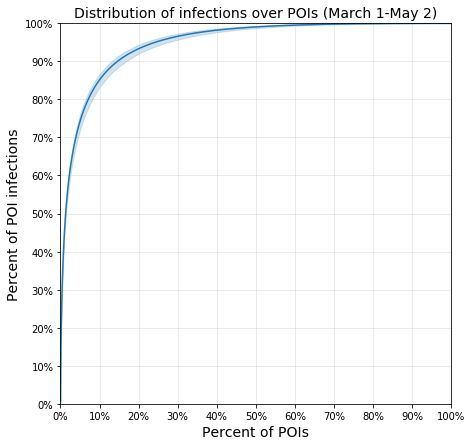

In [32]:
fig, ax = plt.subplots(figsize=(7,7))
out = make_superspreader_plot_for_msa(superspreader_df_cases, HIGHLIGHT_MSA, ax, 
                                poi_and_cbg_characteristics=poi_and_cbg_characteristics)
fig.savefig('covid_figures_for_paper/superspreader_poi_cdf_%s.pdf' % HIGHLIGHT_MSA, bbox_inches='tight')

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


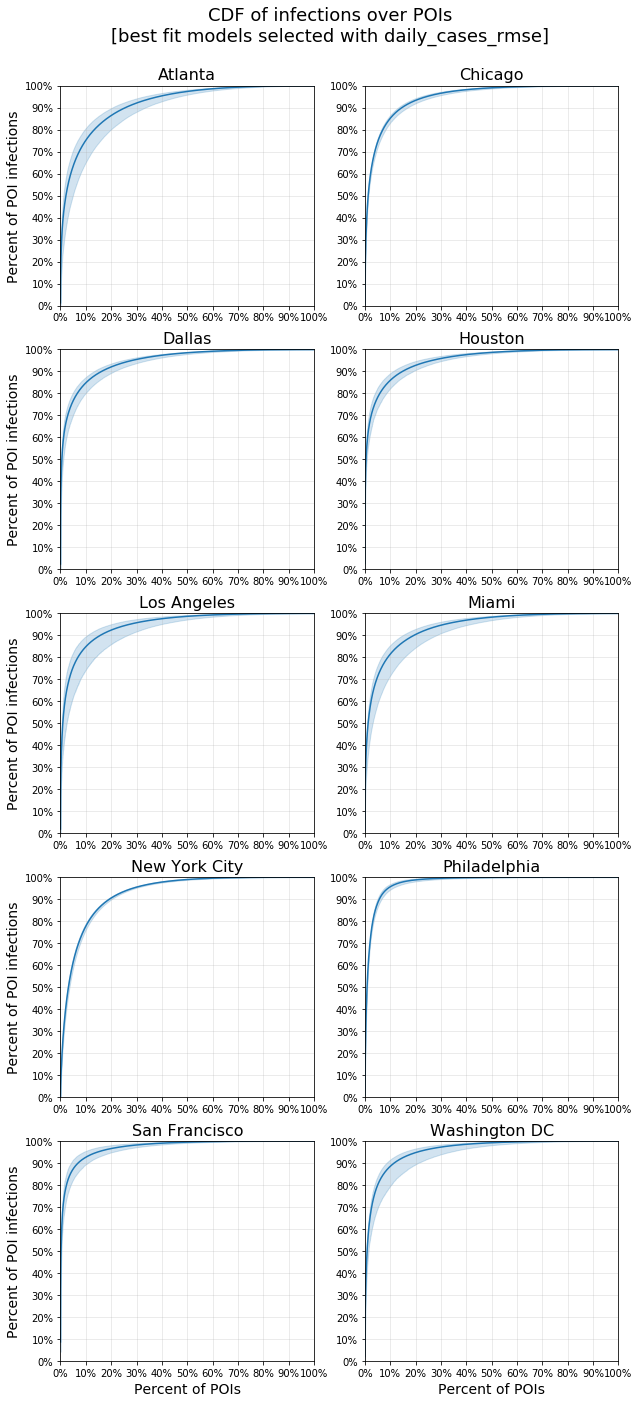

In [43]:
df = superspreader_df_cases
fig, axes = plt.subplots(5, 2, figsize=[10, 22])
axes = [ax for axes_row in axes for ax in axes_row]
fig.suptitle('CDF of infections over POIs\n[best fit models selected with daily_cases_rmse]', fontsize=18)
fig.subplots_adjust(top=.93)
all_proportions_of_total_infections_from_pois = []
for msa_idx, msa in enumerate(MSAS):
    print(msa)
    ax = axes[msa_idx]
    prop_from_pois_df, _ = make_superspreader_plot_for_msa(df, msa, ax, set_labels=False)
    all_proportions_of_total_infections_from_pois.append(prop_from_pois_df)
    if msa_idx % 2 == 0:
        ax.set_ylabel("Percent of POI infections", fontsize=14)   
    if msa_idx >= 8:
        ax.set_xlabel("Percent of POIs", fontsize=14)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=16)

In [44]:
prop_infections_from_pois_to_plot = pd.concat(all_proportions_of_total_infections_from_pois)
print(prop_infections_from_pois_to_plot.groupby('msa').agg(['min', 'mean', 'median', 'max', 'size']))
print("\nOverall stats for medians of MSAs")
print(prop_infections_from_pois_to_plot.groupby('msa').agg('median').agg(['min', 'mean', 'median', 'max', 'size']))

                                            prop_total_infections_from_pois  \
                                                                        min   
msa                                                                           
Atlanta_Sandy_Springs_Roswell_GA                                   0.111430   
Chicago_Naperville_Elgin_IL_IN_WI                                  0.408003   
Dallas_Fort_Worth_Arlington_TX                                     0.363840   
Houston_The_Woodlands_Sugar_Land_TX                                0.472596   
Los_Angeles_Long_Beach_Anaheim_CA                                  0.106390   
Miami_Fort_Lauderdale_West_Palm_Beach_FL                           0.198974   
New_York_Newark_Jersey_City_NY_NJ_PA                               0.648472   
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD                         0.590170   
San_Francisco_Oakland_Hayward_CA                                   0.427995   
Washington_Arlington_Alexandria_DC_VA_MD_WV         

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


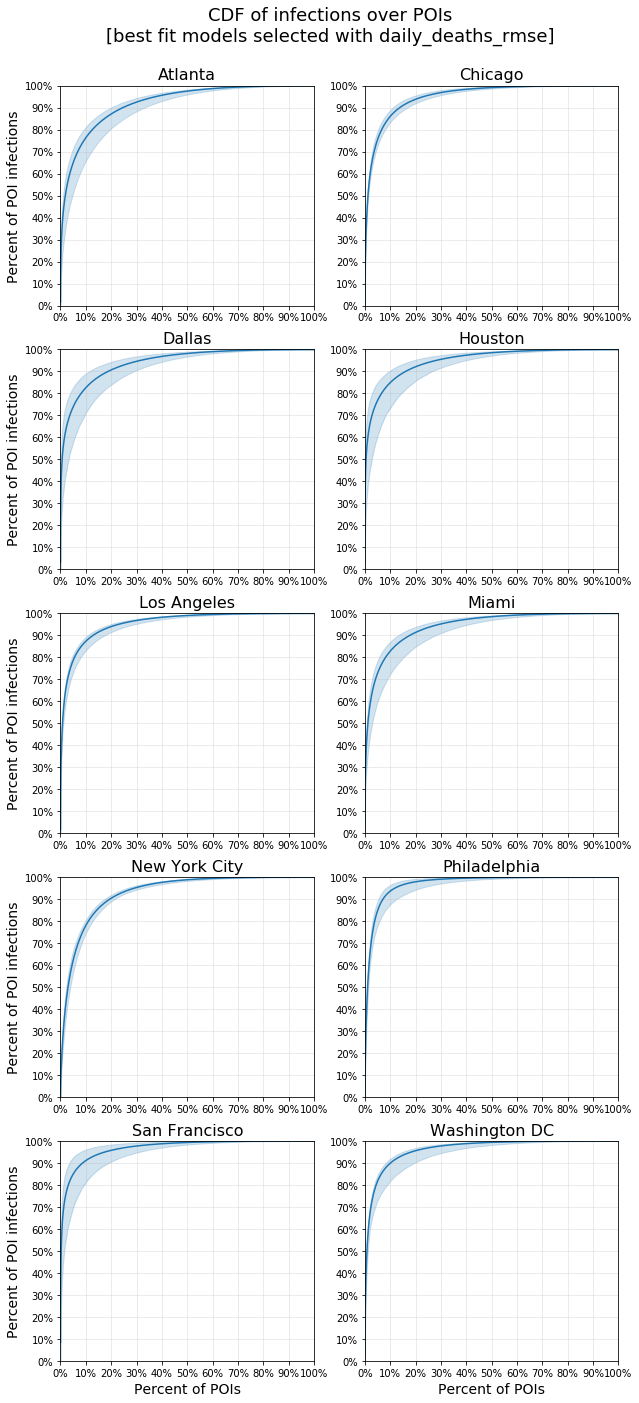

In [45]:
df = superspreader_df_deaths
fig, axes = plt.subplots(5, 2, figsize=[10, 22])
axes = [ax for axes_row in axes for ax in axes_row]
fig.suptitle('CDF of infections over POIs\n[best fit models selected with daily_deaths_rmse]', fontsize=18)
fig.subplots_adjust(top=.93)
all_proportions_of_total_infections_from_pois = []
for msa_idx, msa in enumerate(MSAS):
    print(msa)
    ax = axes[msa_idx]
    prop_from_pois_df, _ = make_superspreader_plot_for_msa(df, msa, ax, set_labels=False)
    all_proportions_of_total_infections_from_pois.append(prop_from_pois_df)
    if msa_idx % 2 == 0:
        ax.set_ylabel("Percent of POI infections", fontsize=14)   
    if msa_idx >= 8:
        ax.set_xlabel("Percent of POIs", fontsize=14)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=16)

## Figure 2c: partial reopening strategies

In [21]:
# load partial reopening with clipping models
min_timestring = '2020_07_20_19_3'
max_timestring = '2020_07_21_15'
max_cap_df = evaluate_all_fitted_models_for_experiment('test_max_capacity_clipping', 
                                                              min_timestring=min_timestring,
                                                              max_timestring=max_timestring)
max_cap_df['MSA_name'] = max_cap_df['data_kwargs'].map(lambda x:x['MSA_name'])
assert (max_cap_df['poi_psi'] > 0).all()

k = 'max_capacity_alpha'
max_cap_df['counterfactual_%s' % k] = max_cap_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k] if k in x else np.nan)
# counterfactual_baseline_models are best-fit models to real data.
max_cap_df['counterfactual_baseline_model'] = max_cap_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
max_cap_df['baseline_model_quality'] = max_cap_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])

Loading models with timestrings between 2020_07_20_19_3 and 2020_07_21_15
47772 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 880 fitted models for test_max_capacity_clipping
Loaded 1 models so far: 0.561s -> 0.561s per model
Time to load and score all models: 19.303s -> 0.022s per model


In [54]:
max_cap_df.groupby('MSA_name').size()

MSA_name
Atlanta_Sandy_Springs_Roswell_GA               150
Chicago_Naperville_Elgin_IL_IN_WI               40
Dallas_Fort_Worth_Arlington_TX                  50
Houston_The_Woodlands_Sugar_Land_TX             80
Los_Angeles_Long_Beach_Anaheim_CA              200
Miami_Fort_Lauderdale_West_Palm_Beach_FL        70
New_York_Newark_Jersey_City_NY_NJ_PA            70
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD      30
San_Francisco_Oakland_Hayward_CA                50
Washington_Arlington_Alexandria_DC_VA_MD_WV    140
dtype: int64

In [26]:
# Make figure 2c, left. 

extra_weeks_to_simulate = max_cap_df.iloc[0]['counterfactual_poi_opening_experiment_kwargs']['extra_weeks_to_simulate']
intervention_datetime = max_cap_df.iloc[0]['counterfactual_poi_opening_experiment_kwargs']['intervention_datetime']
full_activity, intervention_idx = get_full_activity_num_visits(HIGHLIGHT_MSA, 
                                                               intervention_datetime=intervention_datetime,
                                                               extra_weeks_to_simulate=extra_weeks_to_simulate, 
                                                               min_datetime=MIN_DATETIME, 
                                                               max_datetime=MAX_DATETIME)
print(full_activity, intervention_idx)

103699137.4777582 1464


Num params * seeds: 420
Visits lost: [0.66830036316751, 0.4251658026185062, 0.26289625304202974, 0.15907363388617143, 0.09238635525891696, 0.051861841011371757, 0.026702971684137287, 0.01199913523235765, 0.003981731357731452, 0.0]
Visits kept: [0.33169964 0.5748342  0.73710375 0.84092637 0.90761364 0.94813816
 0.97329703 0.98800086 0.99601827 1.        ]
Infections: [6806.6027988813685, 9406.242102994776, 13693.47174626405, 18422.82832710112, 22729.91388223907, 26061.181397764354, 28554.743489028777, 30226.44095329294, 31260.390148755374, 31863.22468776738]


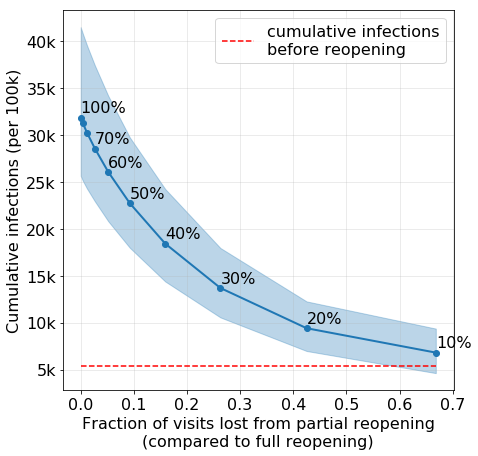

In [48]:
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_df, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=False, 
                                           full_activity_num_visits=full_activity)
fig, ax = plt.subplots(figsize=(7, 7))
make_pareto_plot(X, Y_min, Y_mean, Y_max, ax, all_intervention_lir=all_intervention_lir, 
                 color='tab:blue', point_labels=vals, annotation_color='black')
print('Visits lost:', X)
print('Visits kept:', 1 - np.array(X))
print('Infections:', Y_mean)
x_lim = ax.get_xlim()
plt.show()

In [74]:
# load partial reopening with uniform reduction models
uniform_results = []
min_timestring = '2020_05_31_20_38_59_228416'
required_properties = {'experiment_to_run':'test_uniform_proportion_of_full_reopening'}
for msa in MSAS:
    uniform_results.append(evaluate_all_fitted_models_for_msa(msa, 
                                                      min_timestring=min_timestring,
                                                      max_timestring=max_timestring,
                                                      required_properties=required_properties,
                                                      key_to_sort_by=None))
uniform_df = pd.concat(uniform_results)
uniform_df['MSA_name'] = uniform_df['data_kwargs'].map(lambda x:x['MSA_name'])
assert (uniform_df['poi_psi'] > 0).all()
print("Total models loaded after filtering for uniform reopening experiments: %i" % len(uniform_df))

k = 'full_activity_alpha'
uniform_df['counterfactual_%s' % k] = uniform_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k] if k in x else np.nan)
uniform_df['counterfactual_baseline_model'] = uniform_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
uniform_df['baseline_model_quality'] = uniform_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])

Loading models with timestrings between 2020_05_31_20_38_59_228416 and 2020_06_16
Found 176 fitted models for Atlanta_Sandy_Springs_Roswell_GA
Time to load and score all models: 1.441s -> 0.008s per model
Loading models with timestrings between 2020_05_31_20_38_59_228416 and 2020_06_16
Found 33 fitted models for Chicago_Naperville_Elgin_IL_IN_WI
Time to load and score all models: 0.235s -> 0.007s per model
Loading models with timestrings between 2020_05_31_20_38_59_228416 and 2020_06_16
Found 132 fitted models for Dallas_Fort_Worth_Arlington_TX
Time to load and score all models: 1.595s -> 0.012s per model
Loading models with timestrings between 2020_05_31_20_38_59_228416 and 2020_06_16
Found 99 fitted models for Houston_The_Woodlands_Sugar_Land_TX
Time to load and score all models: 0.765s -> 0.008s per model
Loading models with timestrings between 2020_05_31_20_38_59_228416 and 2020_06_16
Found 220 fitted models for Los_Angeles_Long_Beach_Anaheim_CA
Time to load and score all models: 1

Comparing max_cap_alpha=0.10 to full_activity_alpha=0.34
Num params * seeds: 180
Comparing max_cap_alpha=0.15 to full_activity_alpha=0.48
Num params * seeds: 180
Comparing max_cap_alpha=0.20 to full_activity_alpha=0.60
Num params * seeds: 180
Comparing max_cap_alpha=0.30 to full_activity_alpha=0.76
Num params * seeds: 180
Comparing max_cap_alpha=0.40 to full_activity_alpha=0.86
Num params * seeds: 180
Comparing max_cap_alpha=0.50 to full_activity_alpha=0.92
Num params * seeds: 180
Comparing max_cap_alpha=0.60 to full_activity_alpha=0.95
Num params * seeds: 180
Comparing max_cap_alpha=0.70 to full_activity_alpha=0.97
Num params * seeds: 180
Comparing max_cap_alpha=0.80 to full_activity_alpha=0.99
Num params * seeds: 180
Comparing max_cap_alpha=0.90 to full_activity_alpha=0.99
Num params * seeds: 180
[0.65784254707069, 0.5186568400000003, 0.4037947413405756, 0.2423070769342623, 0.14310755491153962, 0.08084554643898877, 0.04667655828344385, 0.02507355245661761, 0.012436180487085537, 0.005

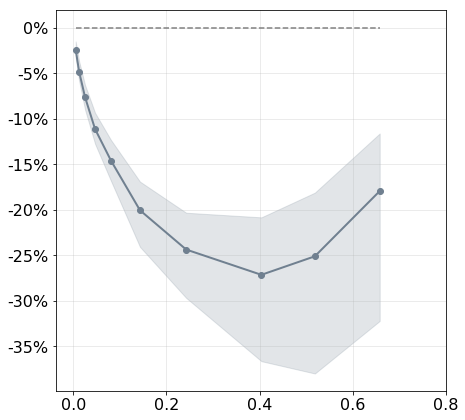

In [35]:
# Make figure 2c, right. 

fig, ax = plt.subplots(figsize=(7, 7))
X, Y_mean, Y_lower, Y_upper = plot_pairwise_comparison(max_cap_df, uniform_df, HIGHLIGHT_MSA, full_activity, 
                                                      intervention_idx, ax, x_lim=x_lim, mode='percent_change',
                                                      set_axis_labels=False)
print(X)
print(Y_mean)
plt.show()

## Figure 3f: disparities in partial reopening impact

Num params * seeds: 420
Overall X: [0.66830036316751, 0.4251658026185062, 0.26289625304202974, 0.15907363388617143, 0.09238635525891696, 0.051861841011371757, 0.026702971684137287, 0.01199913523235765, 0.003981731357731452, 0.0]
Overall Y means: [1468.8601051238506, 4066.970732359021, 8352.905479019588, 13081.453087842396, 17388.064161314884, 20719.065228854026, 23212.47154863359, 24884.128747322386, 25918.045613434388, 26520.864649123254]
Num params * seeds: 420


Bottom decile Y means: [2868.9039418309917, 7613.134397895705, 14648.61555043892, 21589.369054373885, 27146.594576121173, 30950.982883607216, 33511.72457205367, 35106.41716853283, 36034.15939517551, 36593.13971413528]


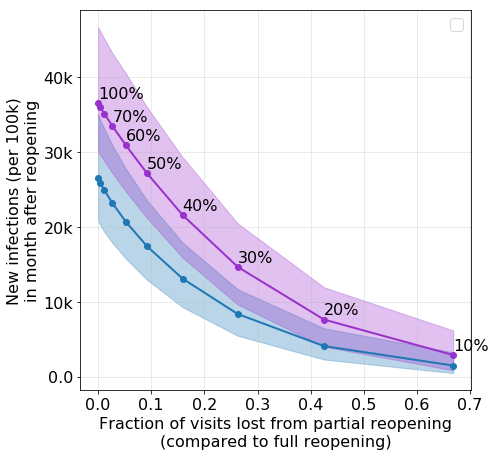

In [49]:
# we include Figure 3f here with Figure 2c bc they are both analyzing the impacts of the 
# clipping reopening strategy and they share code
fig, ax = plt.subplots(figsize=(7, 7))
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_df, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=full_activity, cbg_group='all')
make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                 color='tab:blue', set_axis_labels=False)
print('Overall X:', X)
print('Overall Y means:', Y_mean)
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_df, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=full_activity, cbg_group=LOWINCOME)
make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                 color='darkorchid', point_labels=vals, annotation_color='black')
print('Bottom decile Y means:', Y_mean)

## Figure 2d: Reopening different POI categories

In [27]:
min_timestring = '2020_07_22'
intervention_df = evaluate_all_fitted_models_for_experiment('test_interventions', 
                                                             min_timestring=min_timestring)
intervention_df['MSA_name'] = intervention_df['data_kwargs'].map(lambda x:x['MSA_name'])
for k in ['alpha', 
          'extra_weeks_to_simulate', 
          'intervention_datetime', 
          'top_category', 
          'sub_category']:
    intervention_df['counterfactual_%s' % k] = intervention_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k])
intervention_df['model_fit_rank_for_msa'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])
intervention_df['counterfactual_baseline_model'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
intervention_df['how_to_select_best_grid_search_models'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])
intervention_df_cases = intervention_df.loc[intervention_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
intervention_df_deaths = intervention_df.loc[intervention_df['how_to_select_best_grid_search_models'] == 'daily_deaths_rmse'].copy()
intervention_df_deaths = intervention_df_deaths[intervention_df_deaths['timestring'] >= '2020_07_22_20']  # necessary bc emma ran some experiments on the same day
print('Found %d models for selecting with cases, found %d for selecting with deaths' % 
       (len(intervention_df_cases), len(intervention_df_deaths)))
print(intervention_df_cases.groupby('MSA_name').size())

Found 3880 models for selecting with cases, found 10040 for selecting with deaths
MSA_name
Atlanta_Sandy_Springs_Roswell_GA                640
Chicago_Naperville_Elgin_IL_IN_WI               160
Dallas_Fort_Worth_Arlington_TX                  200
Houston_The_Woodlands_Sugar_Land_TX             320
Los_Angeles_Long_Beach_Anaheim_CA              1000
Miami_Fort_Lauderdale_West_Palm_Beach_FL        280
New_York_Newark_Jersey_City_NY_NJ_PA            280
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD      120
San_Francisco_Oakland_Hayward_CA                200
Washington_Arlington_Alexandria_DC_VA_MD_WV     680
dtype: int64


Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       5858.725913   
1               Fitness Centers       1465.203749   
2            Cafes & Snack Bars       1373.272590   
3               Hotels & Motels       1198.198447   
4   Limited-Service Restaurants        881.411553   
5       Religious Organizations        681.363400   
6         Offices of Physicians        314.651923   
7                Grocery Stores        210.296815   
8       Used Merchandise Stores        137.564168   
9                    Pet Stores        117.542529   
10        Sporting Goods Stores        109.727934   
11         Other General Stores        109.181776   
12 

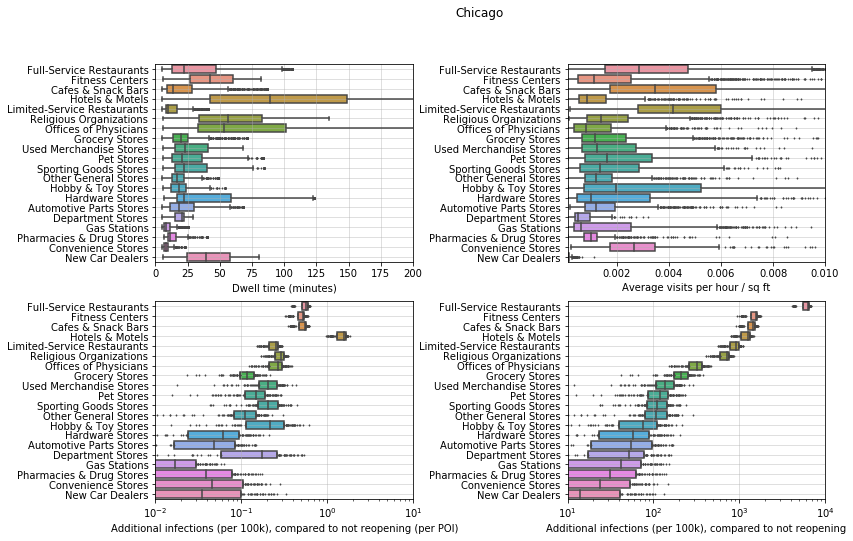

In [30]:
make_boxplot_of_poi_reopening_effects(
    intervention_df_cases, 
    [HIGHLIGHT_MSA], 
    poi_and_cbg_characteristics,
    titlestring=MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA], 
    cats_to_plot=top_categories, 
    filename='covid_figures_for_paper/reopening_impact_boxplots_%s.pdf' % msa)
plt.show()

In [ ]:
for msa in MSAS:
    make_boxplot_of_poi_reopening_effects(intervention_df, 
                                          [msa], 
                                          poi_and_cbg_characteristics, 
                                          titlestring=MSAS_TO_PRETTY_NAMES[msa], 
                                          cats_to_plot=top_categories, 
                                          filename='covid_figures_for_paper/reopening_impact_boxplots_%s.pdf' % msa)
    plt.show()

Making plots using ['Atlanta_Sandy_Springs_Roswell_GA', 'Chicago_Naperville_Elgin_IL_IN_WI', 'Dallas_Fort_Worth_Arlington_TX', 'Houston_The_Woodlands_Sugar_Land_TX', 'Los_Angeles_Long_Beach_Anaheim_CA', 'Miami_Fort_Lauderdale_West_Palm_Beach_FL', 'New_York_Newark_Jersey_City_NY_NJ_PA', 'Philadelphia_Camden_Wilmington_PA_NJ_DE_MD', 'San_Francisco_Oakland_Hayward_CA', 'Washington_Arlington_Alexandria_DC_VA_MD_WV']
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Atlanta_Sandy_Springs_Roswell_GA_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Dallas_Fort_Worth_Arlington_TX_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Houston_The_Woodlands_Sugar_Land_TX_2020-03-01_t

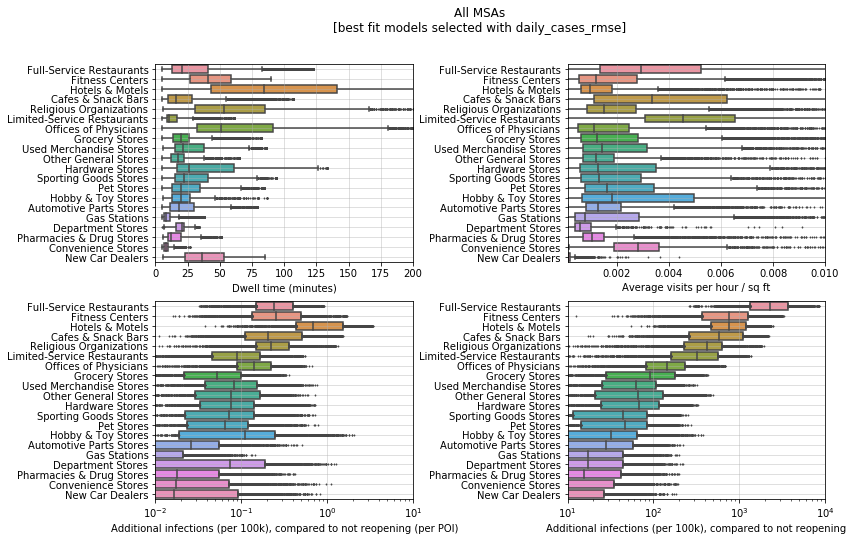

In [35]:
make_boxplot_of_poi_reopening_effects(intervention_df_cases, 
                                      MSAS,
                                      poi_and_cbg_characteristics, 
                                      titlestring='All MSAs\n[best fit models selected with daily_cases_rmse]', 
                                      cats_to_plot=top_categories, 
                                      filename='covid_figures_for_paper/reopening_impact_boxplots_all_MSAs.pdf')
plt.show()

Making plots using ['Atlanta_Sandy_Springs_Roswell_GA', 'Chicago_Naperville_Elgin_IL_IN_WI', 'Dallas_Fort_Worth_Arlington_TX', 'Houston_The_Woodlands_Sugar_Land_TX', 'Los_Angeles_Long_Beach_Anaheim_CA', 'Miami_Fort_Lauderdale_West_Palm_Beach_FL', 'New_York_Newark_Jersey_City_NY_NJ_PA', 'Philadelphia_Camden_Wilmington_PA_NJ_DE_MD', 'San_Francisco_Oakland_Hayward_CA', 'Washington_Arlington_Alexandria_DC_VA_MD_WV']
Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV
Reopening impact quantifies cases per 100000
Pearson correlations between attributes
reopening_impact_per_poi           1.000000
original_dwell_times               0.732545
weighted_visits_over_area          0.079914
d

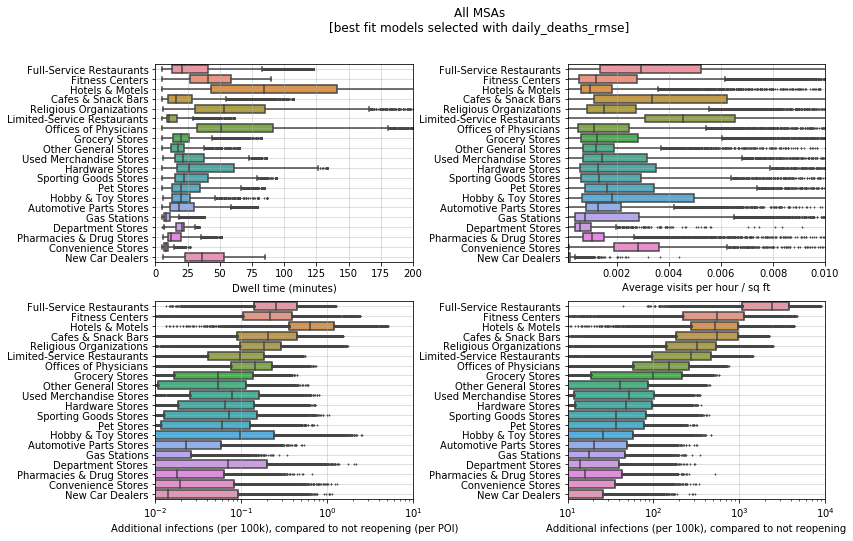

In [38]:
make_boxplot_of_poi_reopening_effects(intervention_df_deaths, 
                                      MSAS,
                                      poi_and_cbg_characteristics, 
                                      titlestring='All MSAs\n[best fit models selected with daily_deaths_rmse]', 
                                      cats_to_plot=top_categories, 
                                      filename='covid_figures_for_paper/reopening_impact_boxplots_all_MSAs.pdf')
plt.show()

## Supplement: disparate impacts of reopening POI categories

In [102]:
plot_reopening_effect_by_poi_category_with_disparate_impact(intervention_df, 
                                      medians_or_deciles='deciles', 
                                      cats_to_plot=top_categories,
                                      filename='covid_figures_for_paper/reopening_by_poi_decile_income.pdf')
plt.show()

Analyzing results for rich and poor deciles
100 models to load for closed df; 2000 models to load for opened interventions
0
10
20
30
40
50
60
70
80
90
   model_fit_rank_for_msa                          MSA_name  top_group_lir_if_closed  bottom_group_lir_if_closed  random_seed
0                       1  Atlanta_Sandy_Springs_Roswell_GA                 0.036842                    0.085884            0
1                       1  Atlanta_Sandy_Springs_Roswell_GA                 0.041475                    0.083627            1
2                       1  Atlanta_Sandy_Springs_Roswell_GA                 0.038591                    0.086285            2
3                       1  Atlanta_Sandy_Springs_Roswell_GA                 0.031802                    0.082919            3
4                       1  Atlanta_Sandy_Springs_Roswell_GA                 0.027818                    0.087319            4
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250

KeyboardInterrupt: 

# Equity analysis

## Figure 3a/b: disparate impact plots 

In [49]:
# selecting based on daily cases 
SES_results = []
all_ses_ratios = []
sort_key_for_ses_analysis = 'loss_dict_daily_cases_RMSE'
print("Using parameters MAX_MODELS_TO_TAKE_PER_MSA=%i and ACCEPTABLE_LOSS_TOLERANCE=%2.3f" % 
      (MAX_MODELS_TO_TAKE_PER_MSA, ACCEPTABLE_LOSS_TOLERANCE))
for city in sorted(list(set(non_ablation_df['MSA_name']))):
    
    city_df = non_ablation_df.loc[(non_ablation_df['MSA_name'] == city)]
    min_loss = city_df[sort_key_for_ses_analysis].min()
    city_df = (city_df.loc[city_df[sort_key_for_ses_analysis] <= (min_loss * ACCEPTABLE_LOSS_TOLERANCE)]
               .sort_values(by=sort_key_for_ses_analysis)
               .iloc[:MAX_MODELS_TO_TAKE_PER_MSA])
    max_ratio = city_df[sort_key_for_ses_analysis].max() / city_df[sort_key_for_ses_analysis].min()
    assert max_ratio > 1 and max_ratio < ACCEPTABLE_LOSS_TOLERANCE
    print("Plotting %i models for %s" % (len(city_df), city))
    for k in ['p_black', 'median_household_income', 'p_white']:

        for comparison in ['medians', 'deciles']:
            if comparison == 'medians':
                disadvantaged_ratios = get_LIR_ratios_from_models(
                        city_df['timestring'], 
                        f'{k}_below_median',
                        f'{k}_above_median')

            else:
                disadvantaged_ratios = get_LIR_ratios_from_models(
                        city_df['timestring'], 
                        f'{k}_bottom_decile',
                        f'{k}_top_decile')
                    
            if k == 'p_black':
                disadvantaged_ratios = 1 / disadvantaged_ratios
                
            # disadvantaged ratios here is n_models x n_seeds
            SES_results.append({"city":city, 
                                'demo':k, 
                                'comparison':comparison, 
                                'median_ratio':np.median(disadvantaged_ratios),
                                'disadvantaged_group_is_more_sick':np.mean(disadvantaged_ratios > 1), 
                               'n':len(city_df)})
            all_ses_ratios.append(pd.DataFrame({'city':city, 
                                                'ratio':disadvantaged_ratios.flatten(),
                                                'comparison':comparison, 
                                                'demo':k}))

    #SES_results.append({"city":city, 'demo':k, 'comparison':'medians', val:above_median_larger})
all_ses_ratios = pd.concat(all_ses_ratios)
all_ses_ratios['MSA'] = all_ses_ratios['city'].map(lambda x:MSAS_TO_PRETTY_NAMES[x])
SES_results = pd.DataFrame(SES_results)
SES_results.loc[(SES_results['demo'] == 'median_household_income')].sort_values(by=['city', 'comparison'])



Using parameters MAX_MODELS_TO_TAKE_PER_MSA=100 and ACCEPTABLE_LOSS_TOLERANCE=1.200
Plotting 16 models for Atlanta_Sandy_Springs_Roswell_GA
Plotting 4 models for Chicago_Naperville_Elgin_IL_IN_WI
Plotting 5 models for Dallas_Fort_Worth_Arlington_TX
Plotting 8 models for Houston_The_Woodlands_Sugar_Land_TX
Plotting 25 models for Los_Angeles_Long_Beach_Anaheim_CA
Plotting 7 models for Miami_Fort_Lauderdale_West_Palm_Beach_FL
Plotting 7 models for New_York_Newark_Jersey_City_NY_NJ_PA
Plotting 3 models for Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Plotting 5 models for San_Francisco_Oakland_Hayward_CA
Plotting 17 models for Washington_Arlington_Alexandria_DC_VA_MD_WV


,city,comparison,demo,disadvantaged_group_is_more_sick,median_ratio,n
3,Atlanta_Sandy_Springs_Roswell_GA,deciles,median_household_income,0.968750,1.625140,16
2,Atlanta_Sandy_Springs_Roswell_GA,medians,median_household_income,0.947917,1.232754,16
9,Chicago_Naperville_Elgin_IL_IN_WI,deciles,median_household_income,1.000000,2.667129,4
8,Chicago_Naperville_Elgin_IL_IN_WI,medians,median_household_income,1.000000,2.017313,4
15,Dallas_Fort_Worth_Arlington_TX,deciles,median_household_income,1.000000,2.639519,5
14,Dallas_Fort_Worth_Arlington_TX,medians,median_household_income,1.000000,1.417964,5
21,Houston_The_Woodlands_Sugar_Land_TX,deciles,median_household_income,0.991667,1.735490,8
20,Houston_The_Woodlands_Sugar_Land_TX,medians,median_household_income,1.000000,1.599249,8
27,Los_Angeles_Long_Beach_Anaheim_CA,deciles,median_household_income,1.000000,4.034546,25
26,Los_Angeles_Long_Beach_Anaheim_CA,medians,median_household_income,1.000000,2.353727,25


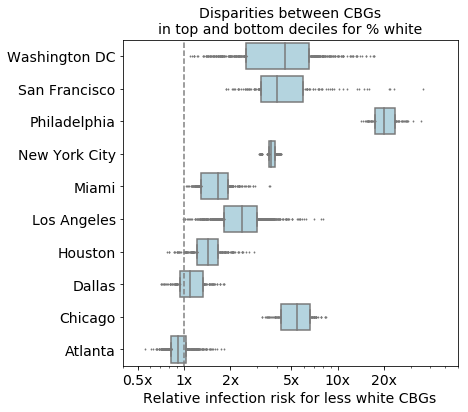

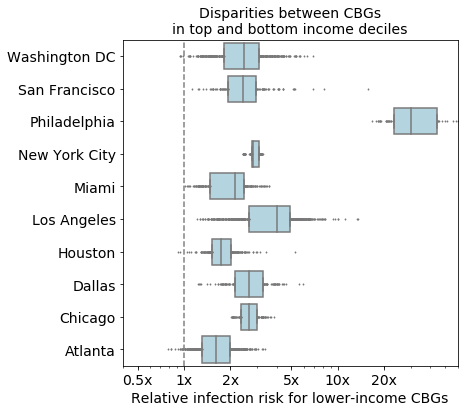

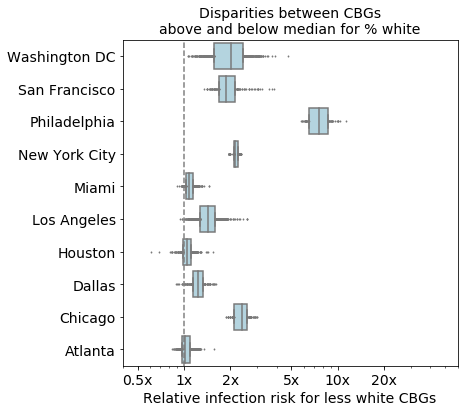

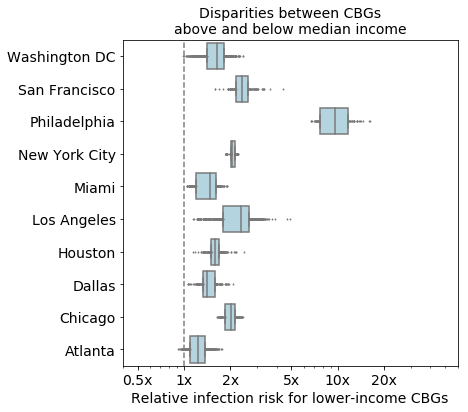

In [50]:
# make plot for paper
for comparison in ['deciles', 'medians']:
    for demographic in ['p_white', 'median_household_income']:
        make_ses_disparities_infection_ratio_plot_for_paper(all_ses_ratios, 
                                                    comparisons=[comparison], 
                                                    demographic=demographic, 
                                                    filename='covid_figures_for_paper/infection_rate_disparities_%s_%s.pdf' 
                                                            % (demographic, comparison))

    

Using parameters MAX_MODELS_TO_TAKE_PER_MSA=100 and ACCEPTABLE_LOSS_TOLERANCE=1.200
Plotting 27 models for Atlanta_Sandy_Springs_Roswell_GA
Plotting 12 models for Chicago_Naperville_Elgin_IL_IN_WI
Plotting 23 models for Dallas_Fort_Worth_Arlington_TX
Plotting 16 models for Houston_The_Woodlands_Sugar_Land_TX
Plotting 12 models for Los_Angeles_Long_Beach_Anaheim_CA
Plotting 20 models for Miami_Fort_Lauderdale_West_Palm_Beach_FL
Plotting 31 models for New_York_Newark_Jersey_City_NY_NJ_PA
Plotting 45 models for Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Plotting 44 models for San_Francisco_Oakland_Hayward_CA
Plotting 21 models for Washington_Arlington_Alexandria_DC_VA_MD_WV


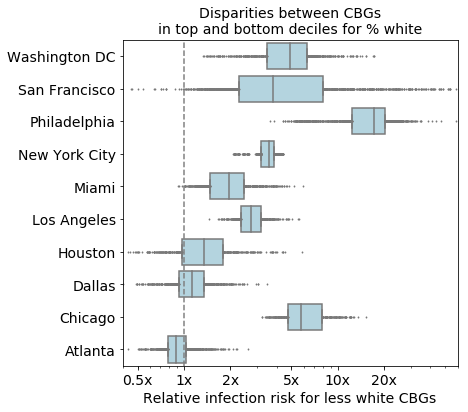

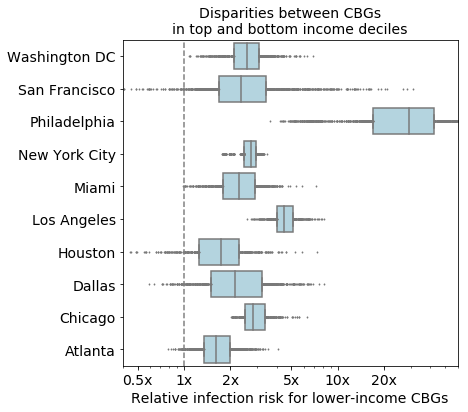

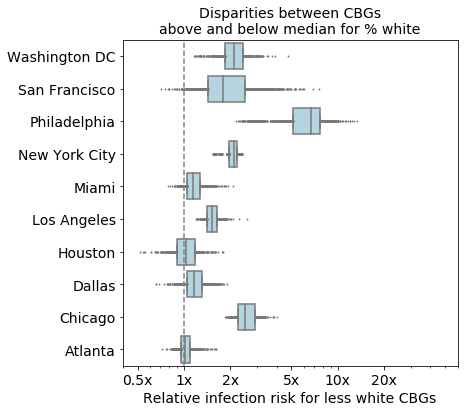

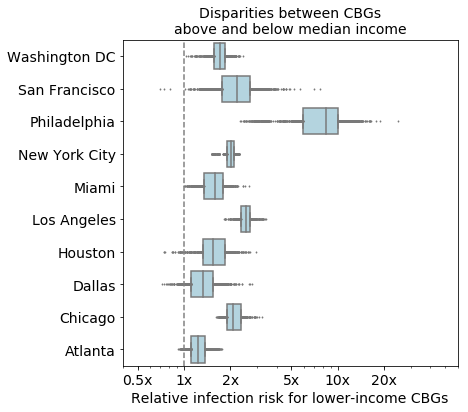

In [51]:
# selecting based on daily deaths 
SES_results = []
all_ses_ratios = []
sort_key_for_ses_analysis = 'loss_dict_daily_deaths_RMSE'
print("Using parameters MAX_MODELS_TO_TAKE_PER_MSA=%i and ACCEPTABLE_LOSS_TOLERANCE=%2.3f" % 
      (MAX_MODELS_TO_TAKE_PER_MSA, ACCEPTABLE_LOSS_TOLERANCE))
for city in sorted(list(set(non_ablation_df['MSA_name']))):
    
    city_df = non_ablation_df.loc[(non_ablation_df['MSA_name'] == city)]
    min_loss = city_df[sort_key_for_ses_analysis].min()
    city_df = (city_df.loc[city_df[sort_key_for_ses_analysis] <= (min_loss * ACCEPTABLE_LOSS_TOLERANCE)]
               .sort_values(by=sort_key_for_ses_analysis)
               .iloc[:MAX_MODELS_TO_TAKE_PER_MSA])
    max_ratio = city_df[sort_key_for_ses_analysis].max() / city_df[sort_key_for_ses_analysis].min()
    assert max_ratio > 1 and max_ratio < ACCEPTABLE_LOSS_TOLERANCE
    print("Plotting %i models for %s" % (len(city_df), city))
    for k in ['p_black', 'median_household_income', 'p_white']:

        for comparison in ['medians', 'deciles']:
            if comparison == 'medians':
                disadvantaged_ratios = get_LIR_ratios_from_models(
                        city_df['timestring'], 
                        f'{k}_below_median',
                        f'{k}_above_median')

            else:
                disadvantaged_ratios = get_LIR_ratios_from_models(
                        city_df['timestring'], 
                        f'{k}_bottom_decile',
                        f'{k}_top_decile')
                    
            if k == 'p_black':
                disadvantaged_ratios = 1 / disadvantaged_ratios
                
            # disadvantaged ratios here is n_models x n_seeds
            SES_results.append({"city":city, 
                                'demo':k, 
                                'comparison':comparison, 
                                'median_ratio':np.median(disadvantaged_ratios),
                                'disadvantaged_group_is_more_sick':np.mean(disadvantaged_ratios > 1), 
                               'n':len(city_df)})
            all_ses_ratios.append(pd.DataFrame({'city':city, 
                                                'ratio':disadvantaged_ratios.flatten(),
                                                'comparison':comparison, 
                                                'demo':k}))

    #SES_results.append({"city":city, 'demo':k, 'comparison':'medians', val:above_median_larger})
all_ses_ratios = pd.concat(all_ses_ratios)
all_ses_ratios['MSA'] = all_ses_ratios['city'].map(lambda x:MSAS_TO_PRETTY_NAMES[x])
SES_results = pd.DataFrame(SES_results)
SES_results.loc[(SES_results['demo'] == 'median_household_income')].sort_values(by=['city', 'comparison'])

# make plot for paper
for comparison in ['deciles', 'medians']:
    for demographic in ['p_white', 'median_household_income']:
        make_ses_disparities_infection_ratio_plot_for_paper(all_ses_ratios, 
                                                    comparisons=[comparison], 
                                                    demographic=demographic, 
                                                    filename='covid_figures_for_paper/infection_rate_disparities_%s_%s.pdf' 
                                                            % (demographic, comparison))

## Figure 3c: disparate impact within POI categories

In [31]:
# add IPF output(i.e., hourly POI-CBG networks) to characteristics
for msa_name in MSAS:
    print(msa_name)
    fn = get_ipf_filename(msa_name, MIN_DATETIME, MAX_DATETIME, True, True)
    print(fn)
    f = open(fn, 'rb')
    poi_cbg_visits_list = pickle.load(f)
    f.close()
    poi_and_cbg_characteristics[msa_name]['poi_cbg_visits_list'] = poi_cbg_visits_list

Atlanta_Sandy_Springs_Roswell_GA
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Atlanta_Sandy_Springs_Roswell_GA_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Chicago_Naperville_Elgin_IL_IN_WI
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Dallas_Fort_Worth_Arlington_TX
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Dallas_Fort_Worth_Arlington_TX_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Houston_The_Woodlands_Sugar_Land_TX
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Houston_The_Woodlands_Sugar_Land_TX_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Los_Angeles_Long_Beach_Anaheim_CA
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Los_Angeles_Long_Beach_Anaheim_CA_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Miami_Fort_Lauderdale_West_Palm_Be

Num params * seeds: 120


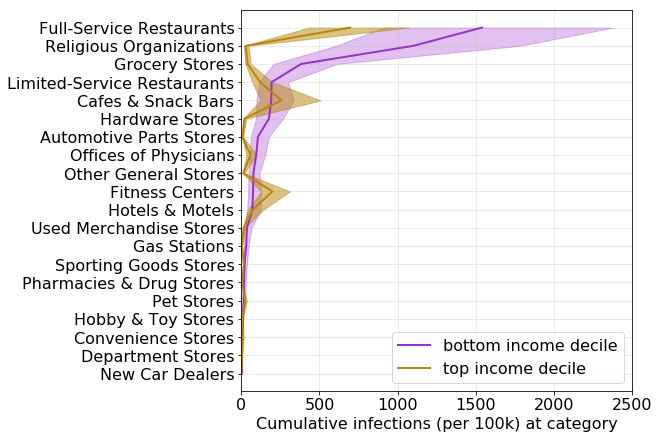

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
category_order = plot_frac_infected_per_category_for_multiple_models(superspreader_df_cases, poi_and_cbg_characteristics, 
                                                                     HIGHLIGHT_MSA, ax, pretty_top_categories)
ax.legend(fontsize=16, loc='lower right')
plt.show()

Atlanta_Sandy_Springs_Roswell_GA
Num params * seeds: 480
Chicago_Naperville_Elgin_IL_IN_WI
Num params * seeds: 120
Dallas_Fort_Worth_Arlington_TX
Num params * seeds: 150
Houston_The_Woodlands_Sugar_Land_TX
Num params * seeds: 240
Los_Angeles_Long_Beach_Anaheim_CA
Num params * seeds: 750
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Num params * seeds: 210
New_York_Newark_Jersey_City_NY_NJ_PA
Num params * seeds: 210
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Num params * seeds: 90
San_Francisco_Oakland_Hayward_CA
Num params * seeds: 150
Washington_Arlington_Alexandria_DC_VA_MD_WV
Num params * seeds: 510


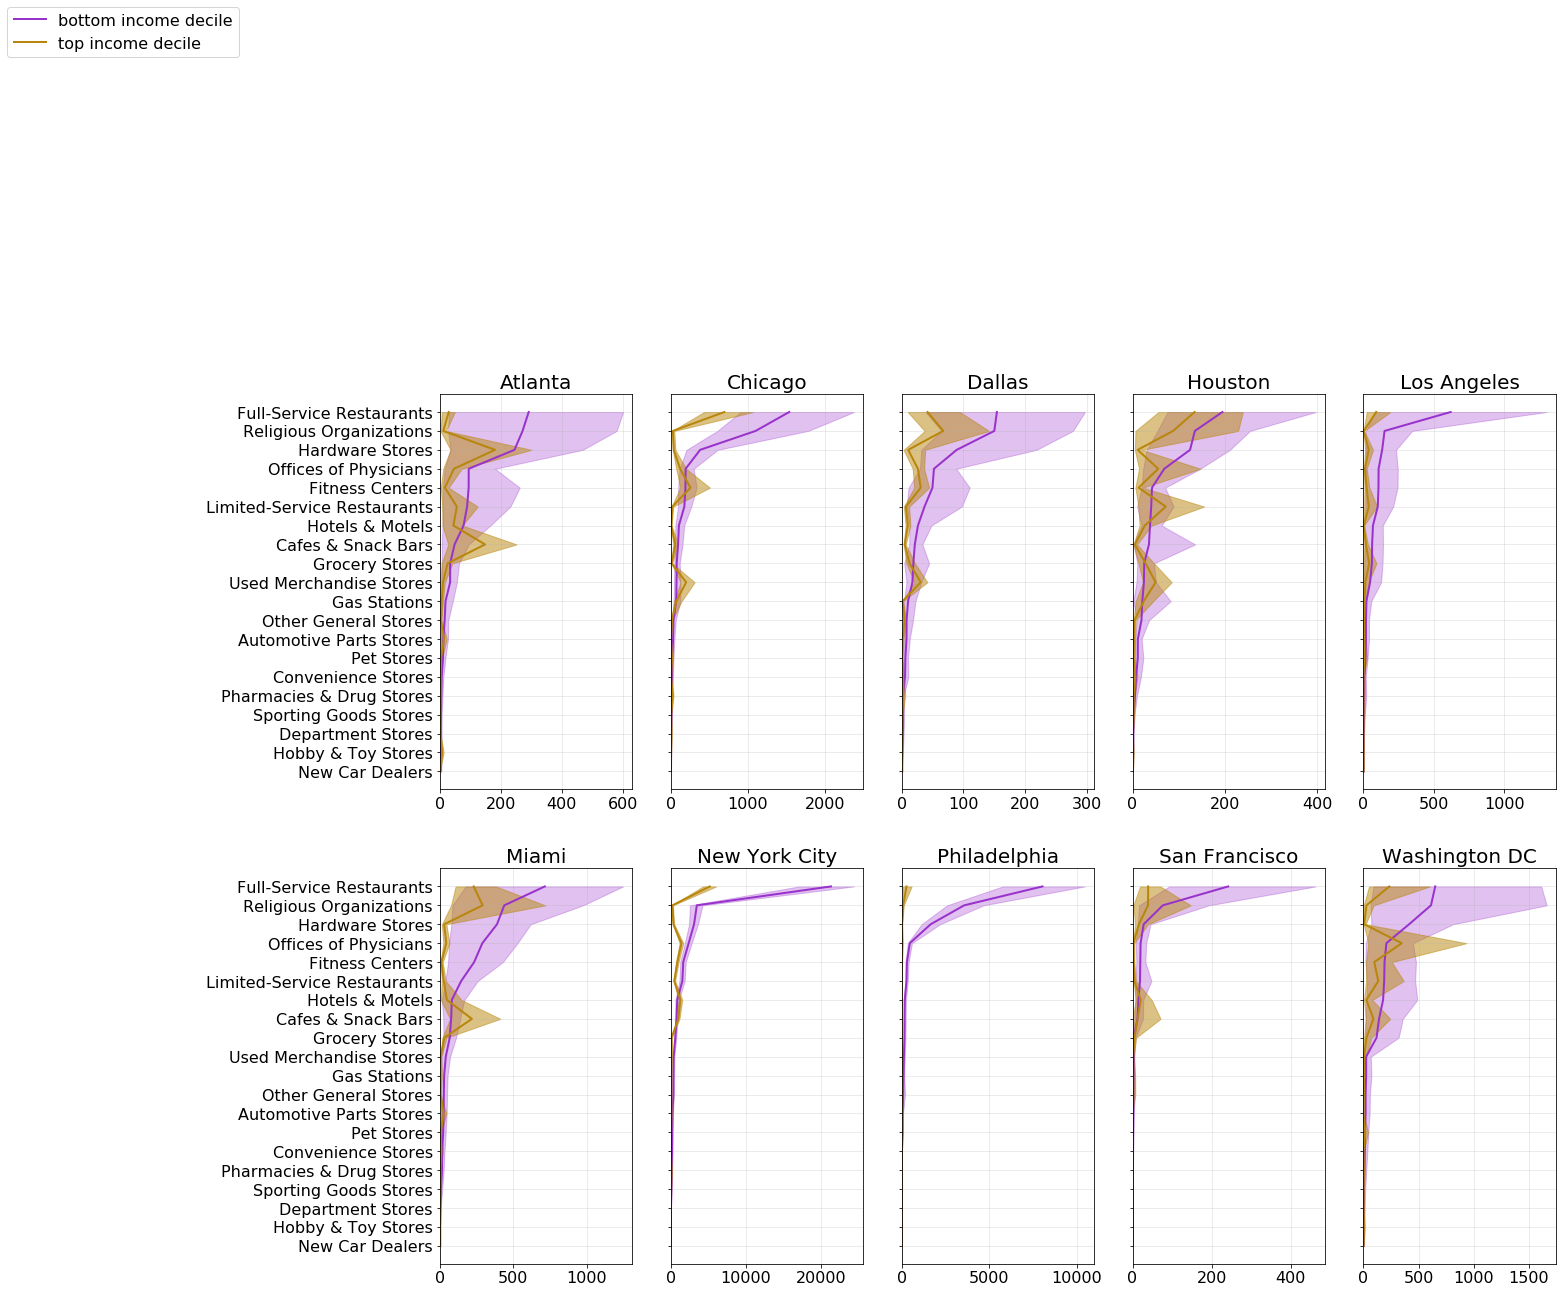

In [34]:
fig, axes = plt.subplots(2, 5, figsize=(20, 16), sharey=True)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    plot_frac_infected_per_category_for_multiple_models(superspreader_df_cases, poi_and_cbg_characteristics, 
                                                        msa_name, ax, pretty_top_categories)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=20)
    ax.set_xlabel('')
    if i == 0:
        ax.legend(bbox_to_anchor=(-1, 2), fontsize=16)
plt.show()

## Figure 3d: mobility over time

/dfs/scratch0/serinac/social_distancing/files_for_public_covid_repo/model_results.py:172: DeprecationWarning: invalid escape sequence \p
  ax.set_xlabel("$\psi$", fontsize=fontsize)


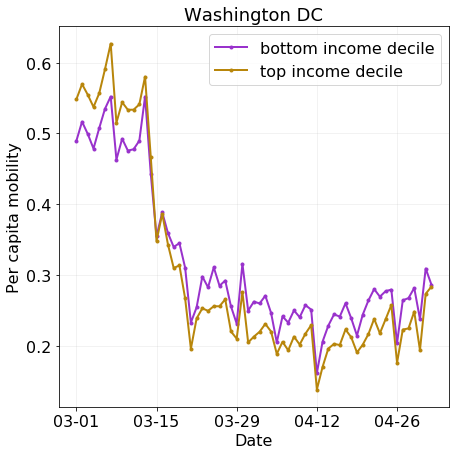

In [60]:
fig, ax = plt.subplots(figsize=(7, 7))
make_mobility_comparison_line_plot(poi_and_cbg_characteristics, HIGHLIGHT_MSA, MIN_DATETIME, MAX_DATETIME, 
                                   LOWINCOME, 'bottom income decile', 'darkorchid',
                                   HIGHINCOME, 'top income decile', 'darkgoldenrod', ax)

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


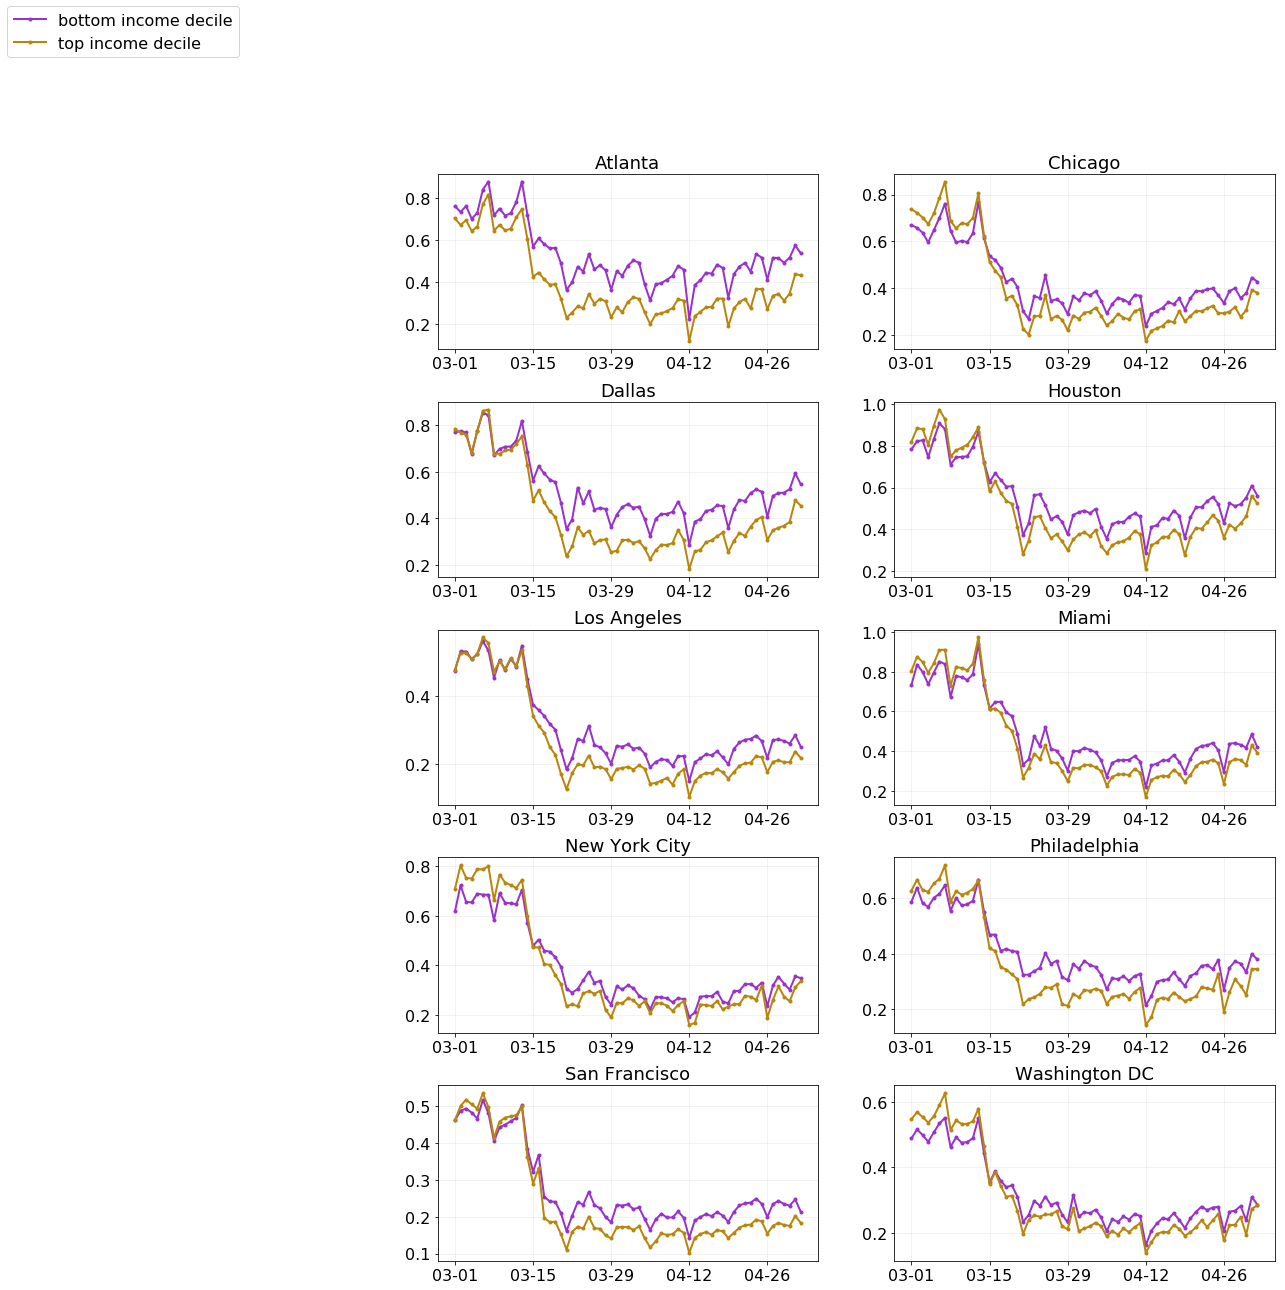

In [61]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.3)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=14)
    make_mobility_comparison_line_plot(poi_and_cbg_characteristics, msa_name, MIN_DATETIME, MAX_DATETIME, 
                                       LOWINCOME, 'bottom income decile', 'darkorchid',
                                       HIGHINCOME, 'top income decile', 'darkgoldenrod', 
                                       ax, set_labels=False)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.5, 2), fontsize=16)
plt.show()

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


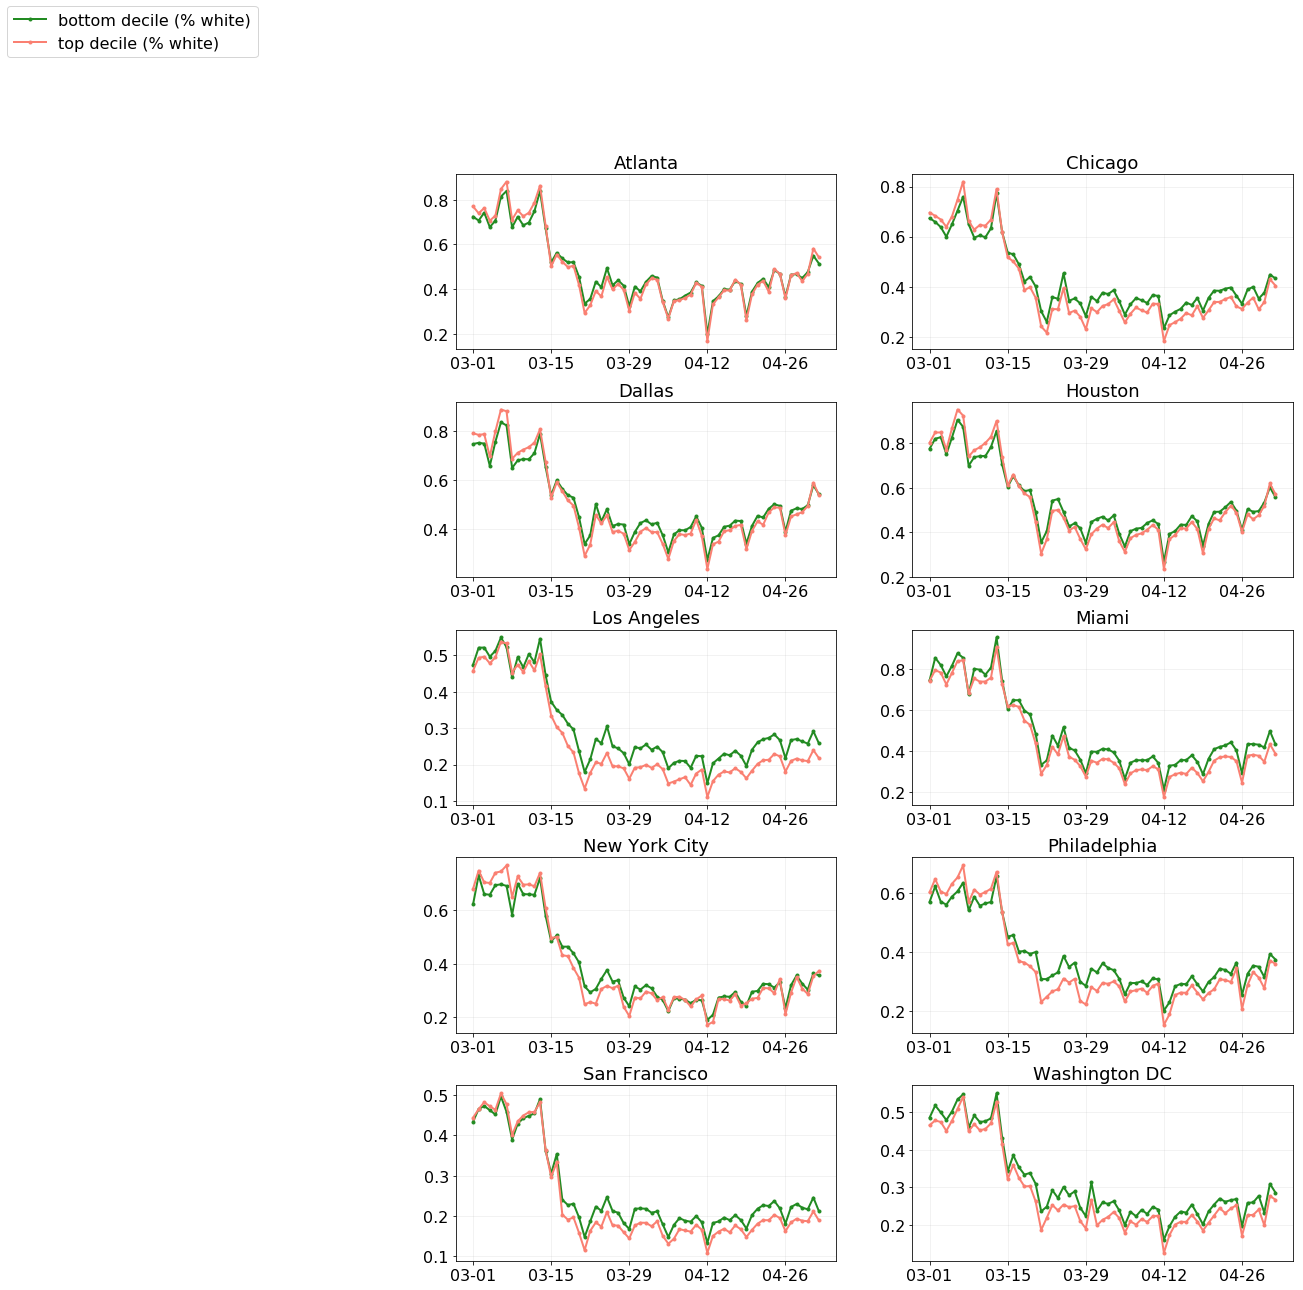

In [62]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.3)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=14)
    make_mobility_comparison_line_plot(poi_and_cbg_characteristics, msa_name, MIN_DATETIME, MAX_DATETIME, 
                                       NONWHITE, 'bottom decile (% white)', 'forestgreen',
                                       WHITE, 'top decile (% white)', 'salmon', 
                                       ax, set_labels=False)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.5, 2), fontsize=16)
plt.show()

## Fig 3e: transmission rates per category

Aggregating data from 1512 hours
Dropped 23160/34937 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 23367/34937 POIs with 0 visits in this time period.


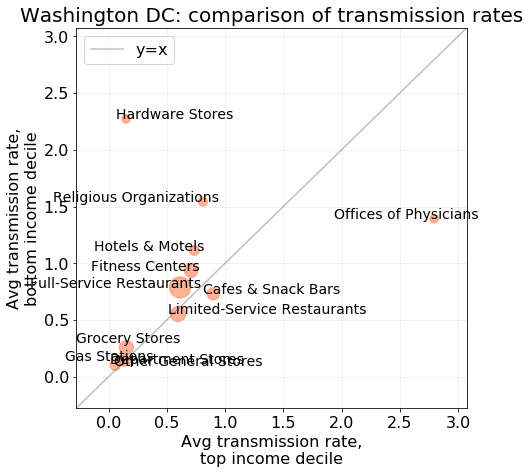

In [73]:
categories_to_plot = pretty_top_categories[:12]
categories_to_label = categories_to_plot
msa_characteristics = poi_and_cbg_characteristics[HIGHLIGHT_MSA]
cbg_idx_groups_to_track = msa_characteristics['cbg_idx_groups_to_track']
cbg_sizes = msa_characteristics['cbg_sizes']

li_poi_attr = get_poi_attributes_for_msa(poi_and_cbg_characteristics, HIGHLIGHT_MSA, group_to_track=LOWINCOME)
li_pop_size = np.sum(cbg_sizes[cbg_idx_groups_to_track[LOWINCOME]])
li_cat_attr = get_category_attributes_from_poi_attributes(li_poi_attr, categories_to_plot, pop_size=li_pop_size)
hi_poi_attr = get_poi_attributes_for_msa(poi_and_cbg_characteristics, HIGHLIGHT_MSA, group_to_track=HIGHINCOME)
hi_pop_size = np.sum(cbg_sizes[cbg_idx_groups_to_track[HIGHINCOME]])
hi_cat_attr = get_category_attributes_from_poi_attributes(hi_poi_attr, categories_to_plot, pop_size=hi_pop_size)

fig, ax = plt.subplots(figsize=(7, 7))
attribute = 'avg_transmission_rate'
title = '%s: comparison of transmission rates' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA]
xlabel = 'Avg transmission rate,\ntop income decile'
ylabel = 'Avg transmission rate,\nbottom income decile'
make_category_comparison_scatter_plot(li_cat_attr, hi_cat_attr, 
                                      attribute, ax, 'coral', title,
                                      xlabel, ylabel, categories_to_label, psi=2000)

## Supplement: transmission rate ratio tables

In [77]:
all_ses_results = get_attribute_ratios_for_all_msas(LOWINCOME, HIGHINCOME, 
                                                    poi_and_cbg_characteristics, pretty_top_categories)

Getting results for Atlanta_Sandy_Springs_Roswell_GA
Aggregating data from 1512 hours
Dropped 27374/40444 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24533/40444 POIs with 0 visits in this time period.
Getting results for Chicago_Naperville_Elgin_IL_IN_WI
Aggregating data from 1512 hours
Dropped 48878/63438 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 40147/63438 POIs with 0 visits in this time period.
Getting results for Dallas_Fort_Worth_Arlington_TX
Aggregating data from 1512 hours
Dropped 36560/53994 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 31355/53994 POIs with 0 visits in this time period.
Getting results for Houston_The_Woodlands_Sugar_Land_TX
Aggregating data from 1512 hours
Dropped 36352/50470 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24300/50470 POIs with 0 visits in this time period.
Getting results for Los_Angeles_Long_Beach

In [78]:
# make summary dataframe of avg_transmission_rate ratios for MSA x category
mat = np.zeros((len(pretty_top_categories), len(MSAS)))
for i, cat in enumerate(pretty_top_categories):
    subdf = all_ses_results[all_ses_results['category'] == cat]
    for j, msa_name in enumerate(MSAS):
        results = subdf[subdf['MSA_name'] == msa_name]
        assert len(results) == 1
        mat[i, j] = round(results['avg_transmission_rate_ratio'], 3)

# median ratio per msa, aggregated over categories
msa_medians = np.round(np.median(mat, axis=0), 3)
for msa, median in zip(MSAS, msa_medians):
    print(msa, median)

cols = [MSAS_TO_PRETTY_NAMES[m] for m in MSAS]
summary_df = pd.DataFrame(mat, columns=cols, index=pretty_top_categories)
summary_df['Med'] = np.round(np.median(summary_df.values, axis=1), 3)
summary_df

Atlanta_Sandy_Springs_Roswell_GA 1.21
Chicago_Naperville_Elgin_IL_IN_WI 1.152
Dallas_Fort_Worth_Arlington_TX 1.006
Houston_The_Woodlands_Sugar_Land_TX 1.048
Los_Angeles_Long_Beach_Anaheim_CA 1.412
Miami_Fort_Lauderdale_West_Palm_Beach_FL 1.202
New_York_Newark_Jersey_City_NY_NJ_PA 1.631
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 2.11
San_Francisco_Oakland_Hayward_CA 1.274
Washington_Arlington_Alexandria_DC_VA_MD_WV 1.504


,Atlanta,Chicago,Dallas,Houston,Los Angeles,Miami,New York City,Philadelphia,San Francisco,Washington DC,Med
Full-Service Restaurants,0.759,1.185,0.977,1.002,1.418,1.273,2.064,2.931,1.725,1.282,1.277
Limited-Service Restaurants,0.883,0.957,0.975,0.898,1.012,0.738,1.787,1.403,0.958,0.927,0.958
Other General Stores,1.058,0.982,1.053,0.725,1.642,0.903,1.501,1.207,1.094,1.061,1.060
Fitness Centers,0.497,0.977,0.839,0.624,1.352,0.750,1.160,1.420,1.000,1.319,0.988
Gas Stations,1.413,1.865,1.391,1.531,2.168,1.844,1.916,6.245,1.261,1.781,1.812
Grocery Stores,0.970,3.038,0.881,1.317,2.397,1.438,4.695,10.416,2.372,1.687,2.030
Cafes & Snack Bars,1.422,0.846,0.749,1.181,1.276,1.878,1.836,1.935,0.941,0.813,1.228
Hotels & Motels,1.362,1.120,0.816,0.759,1.271,1.002,1.026,1.421,1.268,1.511,1.194
Religious Organizations,1.558,1.791,1.035,0.928,1.771,1.435,1.761,1.726,1.549,1.906,1.642
Department Stores,1.204,1.337,0.971,0.923,1.960,2.349,1.316,2.369,1.428,1.600,1.382


In [79]:
all_race_results = get_attribute_ratios_for_all_msas(NONWHITE, WHITE,
                                                     poi_and_cbg_characteristics, pretty_top_categories)

Getting results for Atlanta_Sandy_Springs_Roswell_GA
Aggregating data from 1512 hours
Dropped 31744/40444 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 25545/40444 POIs with 0 visits in this time period.
Getting results for Chicago_Naperville_Elgin_IL_IN_WI
Aggregating data from 1512 hours
Dropped 54434/63438 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 42441/63438 POIs with 0 visits in this time period.
Getting results for Dallas_Fort_Worth_Arlington_TX
Aggregating data from 1512 hours
Dropped 41488/53994 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 33010/53994 POIs with 0 visits in this time period.
Getting results for Houston_The_Woodlands_Sugar_Land_TX
Aggregating data from 1512 hours
Dropped 38805/50470 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 34708/50470 POIs with 0 visits in this time period.
Getting results for Los_Angeles_Long_Beach

In [80]:
# make summary dataframe of avg_transmission_rate ratios for MSA x category
mat = np.zeros((len(pretty_top_categories), len(MSAS)))
for i, cat in enumerate(pretty_top_categories):
    subdf = all_race_results[all_race_results['category'] == cat]
    for j, msa_name in enumerate(MSAS):
        results = subdf[subdf['MSA_name'] == msa_name]
        assert len(results) == 1
        mat[i, j] = round(results['avg_transmission_rate_ratio'], 3)

# median ratio per msa, aggregated over categories
msa_medians = np.round(np.median(mat, axis=0), 3)
for msa, median in zip(MSAS, msa_medians):
    print(msa, median)

cols = [MSAS_TO_PRETTY_NAMES[m] for m in MSAS]
summary_df = pd.DataFrame(mat, columns=cols, index=pretty_top_categories)
summary_df['Med'] = np.round(np.median(summary_df.values, axis=1), 3)
summary_df

/dfs/scratch0/serinac/social_distancing/files_for_public_covid_repo/model_results.py:172: DeprecationWarning: invalid escape sequence \p
  ax.set_xlabel("$\psi$", fontsize=fontsize)


Atlanta_Sandy_Springs_Roswell_GA 0.947
Chicago_Naperville_Elgin_IL_IN_WI 1.437
Dallas_Fort_Worth_Arlington_TX 0.96
Houston_The_Woodlands_Sugar_Land_TX 0.928
Los_Angeles_Long_Beach_Anaheim_CA 1.26
Miami_Fort_Lauderdale_West_Palm_Beach_FL 1.096
New_York_Newark_Jersey_City_NY_NJ_PA 1.918
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 2.657
San_Francisco_Oakland_Hayward_CA 1.184
Washington_Arlington_Alexandria_DC_VA_MD_WV 1.346


,Atlanta,Chicago,Dallas,Houston,Los Angeles,Miami,New York City,Philadelphia,San Francisco,Washington DC,Med
Full-Service Restaurants,0.770,1.398,0.982,0.902,1.077,1.145,2.396,2.628,1.179,1.100,1.122
Limited-Service Restaurants,0.881,1.062,0.964,0.921,0.719,0.939,2.238,1.340,0.899,1.423,0.952
Other General Stores,0.761,1.244,0.890,0.822,1.825,0.907,2.118,1.071,0.980,1.243,1.026
Fitness Centers,0.632,1.130,0.723,0.792,0.777,0.949,1.485,1.857,0.938,1.339,0.944
Gas Stations,1.403,1.907,1.459,1.063,1.173,1.639,1.574,2.698,2.121,1.353,1.517
Grocery Stores,0.536,3.617,0.645,1.277,2.276,1.001,5.194,13.531,2.296,1.862,2.069
Cafes & Snack Bars,1.299,1.096,0.734,0.882,0.896,2.575,1.657,2.685,1.159,0.843,1.128
Hotels & Motels,1.008,1.016,1.365,0.824,1.262,1.132,1.333,2.375,0.707,1.000,1.074
Religious Organizations,0.964,1.633,1.023,0.935,2.129,1.725,1.949,2.031,1.610,1.205,1.622
Department Stores,1.188,1.637,0.740,0.853,1.045,5.333,6.125,3.607,2.347,1.642,1.640


## Supplement: num visits per capita to POI categories

Aggregating data from 1512 hours
Dropped 23160/34937 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 23367/34937 POIs with 0 visits in this time period.


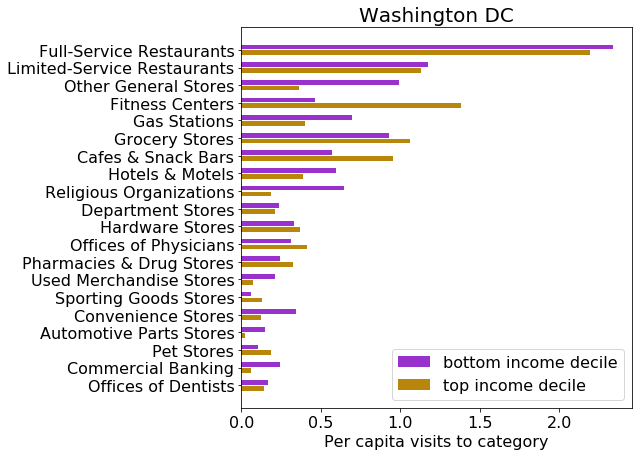

In [84]:
fig, ax = plt.subplots(figsize=(7,7))
plot_per_capita_category_visits(poi_and_cbg_characteristics, HIGHLIGHT_MSA, 
                                LOWINCOME, 'bottom income decile', 'darkorchid',
                                HIGHINCOME, 'top income decile', 'darkgoldenrod', 
                                pretty_top_categories, ax)